<a href="https://colab.research.google.com/github/eflatlan/CNN_PID/blob/models_sacved/newArc_segment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [201]:
!pip install h5py numpy

import os
import h5py
import numpy as np

from google.colab import drive
drive.mount('/content/drive')



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [202]:
import numpy as np
import numpy as np

def extract_neighborhood_map(candidate_positions, mip_positions, neighborhood_size, map_size):
    num_samples = candidate_positions.shape[0]
    num_candidates = candidate_positions.shape[1]


    print(f"candidate_positions shape = {candidate_positions.shape}")

    # Calculate distances between candidate positions and MIP positions
    distances = candidate_positions - mip_positions[:, np.newaxis, :]

    # Calculate the norm of distances to get the Euclidean distance
    distances = np.linalg.norm(distances, axis=-1)

    # Create an empty map for each particle type (pion, kaon, proton)
    neighborhood_maps = np.zeros((num_samples, neighborhood_size, neighborhood_size))



    print(f"apply mask:")
# Check if candidate falls within the neighborhood and update the map
    mask = distances <= neighborhood_size
    map_indices = np.round(candidate_positions).astype(int)

    # Adjust the indices to ensure they are within valid range
    map_indices[:, :, 0] = np.clip(map_indices[:, :, 0], 0, neighborhood_size - 1)
    map_indices[:, :, 1] = np.clip(map_indices[:, :, 1], 0, neighborhood_size - 1)

    neighborhood_maps[np.arange(num_samples)[:, np.newaxis],
                      map_indices[:, :, 1], map_indices[:, :, 0]] = mask

    print(f"neighborhood_maps shape = {neighborhood_maps.shape}")
    map_sample = neighborhood_maps[1]

    # Plot the map
    plt.imshow(map_sample, cmap='gray')
    plt.colorbar()
    plt.title("Neighborhood Map for num_samples = 1")
    plt.xlabel("X-axis")
    plt.ylabel("Y-axis")
    plt.show()


    map_sample = neighborhood_maps[2]

    # Plot the map
    plt.imshow(map_sample, cmap='gray')
    plt.colorbar()
    plt.title("Neighborhood Map for num_samples = 2")
    plt.xlabel("X-axis")
    plt.ylabel("Y-axis")
    plt.show()
    return neighborhood_maps


import tensorflow as tf
from tensorflow.keras import layers, models, Input

import tensorflow as tf
from tensorflow.keras import layers, models, Input


def create_cnn_model(input_shape=None, name="default_name"):
    # Create CNN layers
    cnn_input = Input(shape=input_shape)
    x = layers.Conv2D(32, (3, 1), activation='relu', name=f"conv2D_1_{name}")(cnn_input)
    # x = layers.MaxPooling2D((2, 1), name=f"MaxPooling2D_1_{name}")(x)
    # x = layers.Conv2D(64, (5, 1), activation='relu', name=f"conv2D_2_{name}")(x)
    # x = layers.MaxPooling2D((2, 1), name=f"MaxPooling2D_2_{name}")(x)
    # x = layers.Conv2D(64, (7, 1), activation='relu', name=f"conv2D_3_{name}")(x)
    cnn_output = layers.Reshape((-1, 1), name=f"Reshape_{name}")(x)

    return models.Model(inputs=cnn_input, outputs=cnn_output)


In [203]:
#!wget https://raw.githubusercontent.com/eflatlan/CNN_PID/dev_floatmap/helper_functions.py
#from helper_functions.py import print_points, plot_mapsm

In [204]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np

from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np

from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np

import numpy as np

def pad_and_stack(sequences, max_length=None):
    # Your existing code
    try:
        # Try padding, if max_length is not None, pad or truncate to that length
        padded_sequences = pad_sequences(sequences, maxlen=max_length, padding='post', dtype='int32')  # Changed dtype to 'int32'
    except ValueError:
        # Fallback: manually pad with zeros
        max_len = max_length if max_length is not None else max(len(seq) for seq in sequences)
        padded_sequences = np.array([np.pad(seq, (0, max_len - len(seq)), 'constant', constant_values=0) for seq in sequences])

    return padded_sequences






def classify_candidates_with_pad_sequences(x_values_data, y_values_data, chi2_values_data, q_values_data, xe_values_data, ye_values_data, candStatus_values_data, max_length_nested):


    # Pad the sequences
    print(f"x_values_data Type of sequences: {type(x_values_data)}, shape of sequences: {np.shape(x_values_data)}")
    print(f"Type of sequences: {type(y_values_data)}, shape of sequences: {np.shape(y_values_data)}")
    print(f"Type of sequences: {type(chi2_values_data)}, shape of sequences: {np.shape(chi2_values_data)}")
    print(f"Type of sequences: {type(q_values_data)}, shape of sequences: {np.shape(q_values_data)}")
    print(f"Type of sequences: {type(candStatus_values_data)}, shape of sequences: {np.shape(candStatus_values_data)}")

    print(type(x_values_data), np.shape(x_values_data))
    if np.ndim(x_values_data) == 1:
        x_values_data = np.expand_dims(x_values_data, axis=-1)

    x_padded = pad_and_stack(x_values_data, max_length=max_length_nested)
    y_padded = pad_and_stack(y_values_data, max_length=max_length_nested)
    chi2_padded = pad_and_stack(chi2_values_data, max_length=max_length_nested)
    q_padded = pad_and_stack(q_values_data, max_length=max_length_nested)
    xe_padded = pad_and_stack(xe_values_data, max_length=max_length_nested)
    ye_padded = pad_and_stack(ye_values_data, max_length=max_length_nested)
    candStatus_padded = pad_and_stack(candStatus_values_data, max_length=max_length_nested)
    candStatus_padded = candStatus_padded.astype(int)
    # Stack the data into a single array
    padded_data = np.stack([x_padded, y_padded, chi2_padded, q_padded, xe_padded, ye_padded, candStatus_padded], axis=-1)

    # Create masks for different particle types based on 'candStatus'
    pion_mask = (candStatus_padded & 4).astype(bool)
    kaon_mask = (candStatus_padded & 2).astype(bool)
    proton_mask = (candStatus_padded & 1).astype(bool)

    # Initialize arrays for particle candidates
    pion_candidates = np.zeros_like(padded_data)
    kaon_candidates = np.zeros_like(padded_data)
    proton_candidates = np.zeros_like(padded_data)
    non_candidates = np.zeros_like(padded_data)

    # Populate particle candidates arrays
    pion_candidates[pion_mask] = padded_data[pion_mask]
    kaon_candidates[kaon_mask] = padded_data[kaon_mask]
    proton_candidates[proton_mask] = padded_data[proton_mask]
    non_candidates[~(pion_mask | kaon_mask | proton_mask)] = padded_data[~(pion_mask | kaon_mask | proton_mask)]

    #return pion_candidates, kaon_candidates, proton_candidates, non_candidates
    return non_candidates, non_candidates, non_candidates, non_candidates, candStatus_padded


In [205]:
def classify_candidates(x_values_data, y_values_data, chi2_values_data,  q_values_data, xe_values_data,  ye_values_data, candStatus_values_data):
    pion_candidates = []
    kaon_candidates = []
    proton_candidates = []
    non_candidates = []

    for i in range(len(x_values_data)):
        candStatus = int(candStatus_values_data[i])

        complete_candidate_data = [
            x_values_data[i], y_values_data[i], chi2_values_data[i],  q_values_data[i], xe_values_data[i],  ye_values_data[i], candStatus_values_data[i]
        ]

        is_candidate = False
        # ef : now removed classification
        if true or candStatus & 4:  # Pion
            pion_candidates.append(complete_candidate_data)
            is_candidate = True

        if true or candStatus & 2:  # Kaon
            kaon_candidates.append(complete_candidate_data)
            is_candidate = True

        if true or candStatus & 1:  # Proton
            proton_candidates.append(complete_candidate_data)
            is_candidate = True

        if not is_candidate:  # None of the above
            non_candidates.append(complete_candidate_data)

    #return pion_candidates, kaon_candidates, proton_candidates, non_candidates
    return non_candidates, non_candidates, non_candidates, non_candidates


In [206]:
import matplotlib.pyplot as plt

def plot_first_instance(X_pion, X_kaon, X_proton, MIP_position, RAD_position, phiP, thetaP):
    i = 5
    # Extract values for the first instance
    phiP_val = phiP[i]
    thetaP_val = thetaP[i]

    print(f"plot_first_instance {X_pion[i].shape} ")
    XYp = X_pion[i]
    Xp = XYp[:, 0]  # All rows of the first column (X-coordinate)
    Yp = XYp[:, 1]  # All rows of the second column (Y-coordinate)

    XYk = X_kaon[i]
    Xk = XYk[:, 0]  # All rows of the first column (X-coordinate)
    Yk = XYk[:, 1]  # All rows of the second column (Y-coordinate)

    XYpr = X_proton[i]
    Xpr = XYpr[:, 0]  # All rows of the first column (X-coordinate)
    Ypr = XYpr[:, 1]  # All rows of the second column (Y-coordinate)

    # Plotting X_pion, X_kaon, and X_proton
    plt.scatter(Xp, Yp, color='red', label='X_pion')
    plt.scatter(Xk, Yk, color='blue', label='X_kaon')
    plt.scatter(Xpr, Ypr, color='black', label='X_proton')

    xm, ym = MIP_position[i]
    xr, yr = RAD_position[i]

    # Plotting MIP_position and RAD_position
    plt.scatter(xm, ym, color='green', marker='x', label='MIP_position')
    plt.scatter(xr, yr, color='orange', marker='x', label='RAD_position')

    # Adding phiP and thetaP to the title (converting to float)
    plt.title(f"First Instance\nphiP: {float(phiP_val):.2f}, thetaP: {float(thetaP_val):.2f}")

    # Setting the aspect ratio to equal
    plt.axis('equal')

    # Adding legend
    plt.legend()

    # Displaying the plot
    plt.show()



In [207]:
#@title Default title text
from __future__ import print_function
import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import norm
import os
import h5py
import tensorflow as tf

# to check the impact of resolution in the 2d-map;
# print the difference between the filledBins vector versus the map (map is restricted by resolution)
def print_points(filled_bins_array = None, map_array = None, mip_position_array = None, resolution = 10):

    length = map_array.shape[0]
    distances_bins_list = []
    distances_map_list = []

    print(f"filled_bins_array shape = {filled_bins_array.shape}")
    print(f"map_array shape = {map_array.shape}")
    print(f"mip_position_array shape = {mip_position_array.shape}")


    for i in range (1, length):

        filled_bins = np.array(filled_bins_array[i])
        map = np.array(map_array[i, :,:])
        mip_pos = np.array(mip_position_array[i, :])

        #print(f"filled_bins shape = {filled_bins.shape}")
        #print(f"map shape = {map.shape}")
        #print(f"mip_pos shape = {mip_pos.shape}")

        _mip_position = []
        #_mip_position.append(mip_position_array[])
        distances2 = []

        distances_bins = [norm(np.array(pos) - mip_pos) for pos in filled_bins]

        distances_map = []
        for y in range(map.shape[0]):
            for x in range(map.shape[1]):
                if map[y, x] == 1:
                    point = (x, y)
                    distance = np.linalg.norm(np.array(point) - mip_pos*resolution)
                    distances_map.append(distance)



        distances_bins_list.append(distances_bins)
        distances_map_list.append(distances_map)


    # Print the distances for each element in map_data_list
    print(f"Element {i+1} distances:")
    for j, (distances_bins, distances_map) in enumerate(zip(distances_bins_list, distances_map_list)):
        print(f"  Point {j+1}: Distance bins: {distances_bins}\n, Distance map: {distances_map}")
    print()




def plot_maps(filled_bins_array=None, map_array=None, mip_position_array=None, X_momentum=None, X_refractive_index=None, percentage_to_plot=5, resolution = 10):
  """
  Args : filled_bins_array : array that holds the vectors of filled pads
         map_array : 2d  map with a determined resolution (the points in the filled_bins_array element, just restricted by the resolution)
         mip_position_array : array of the MIP {x, y} positions

         TODO : add mass_category and actual mass?
  """


  #percentage_to_plot = 0.05 / 10

  # Calculate the starting index of the samples to plot
  num_samples = map_array.shape[0]
  start_index = -num_samples

  # Create a subplot with the number of rows based on the number of samples
  fig, axes = plt.subplots(nrows=5, ncols=1, figsize=(8, 20))

  # Iterate over the samples and plot each map with information
  for i, ax in enumerate(axes):
      # Get the map and corresponding information
      map_data = map_array[start_index + i, :, :]
      #mass_category = particle_vector[start_index + i].mass_category
      PDG = PDG[start_index + i]
      mip_position = mip_position_array[start_index + i]
      momentum = X_momentum[start_index + i]
      refractive_index = X_refractive_index[start_index + i]

      # Plot the map
      ax.imshow(map_data, cmap='gray')



      #try :
      # Add a red dot at the MIP position
      ax.plot(mip_position[0]*resolution, mip_position[1]*resolution, 'ro')
      #Except exception as e :
      #  print("caught non mip pos ")
      # Set the title with the information
      #ax.set_title(f"Mass: {mass_category}, CKOV: {ckov}, MIP Position: {mip_position}, Momentum: {momentum},  refractive_index: {refractive_index}")
      ax.set_title(f"PDG: {PDG}, MIP Position: {mip_position}, Momentum: {momentum},  refractive_index: {refractive_index}")

      ax.axis('off')

  # Adjust the spacing between subplots
  plt.tight_layout()

  # Show the plot
  plt.show()

In [208]:
def create_lr_scheduler(num_epochs=10, warmup_epochs=50):


    # endre warmup_epochs

    start_lr = 0 # Starting learning rate is 0 for the warm-up
    peak_lr = 0.001/(5*1.2) # was /5 # The learning rate we reach at the end of the warm-up
    end_lr = 5e-6   # The final learning rate at the end of training

    # Calculate decay rate based on peak and end learning rate
    # Notice we adjust the total number of epochs by subtracting the warm-up period
    exp_decay = -np.log(end_lr / peak_lr) / (num_epochs - warmup_epochs)

    # Warm-up followed by exponential decay
    def schedule(epoch):
        if epoch < warmup_epochs:
            return start_lr + ((peak_lr - start_lr) / (warmup_epochs - 1)) * epoch
        else:
            return peak_lr * np.exp(-exp_decay * (epoch - warmup_epochs))

    return tf.keras.callbacks.LearningRateScheduler(schedule)




def plot_lr(num_epochs = 10, history = None):
  div = num_epochs/4
  lrs = 1e-4 * (10 ** (np.arange(num_epochs)/div))
  plt.figure(figsize=(10, 7))
  plt.semilogx(lrs, history.history["loss"]) # we want the x-axis (learning rate) to be log scale
  plt.xlabel("Learning Rate")
  plt.ylabel("Loss")


  plt.title("Learning rate vs. loss");

!wget -O helper_functions.py https://raw.githubusercontent.com/eflatlan/CNN_PID/models_sacved/helper_functions.py
!wget -O plot_helper_functions.py https://raw.githubusercontent.com/eflatlan/CNN_PID/models_sacved/plot_helper_functions.py

import plot_helper_functions

from plot_helper_functions import plot_training_history
#from plot_helper_functions import plot_training_history#, plot_dist2mip_histograms, plot_maps


--2023-09-07 12:26:51--  https://raw.githubusercontent.com/eflatlan/CNN_PID/models_sacved/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 14594 (14K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  14.25K  --.-KB/s    in 0s      

2023-09-07 12:26:51 (113 MB/s) - ‘helper_functions.py’ saved [14594/14594]

--2023-09-07 12:26:51--  https://raw.githubusercontent.com/eflatlan/CNN_PID/models_sacved/plot_helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length:

In [209]:
#def plot_worst_(model, y_test, X_test_map, X_test_momentum, X_test_refractive_index, X_test_ckov, X_test_mip_position, y_pred):
def plot_maps(filled_bins_array=None, map_array=None, mip_position_array=None, X_momentum=None, X_refractive_index=None, X_ckov=None, percentage_to_plot=5, resolution = 10):
  #  print("Shape of y_pred: ", y_pred.shape)
  # 1. Predict labels on validation data
  #plot_worst(model, y_test, X_test["X_test_map"], X_test["X_test_momentum"], X_test["X_test_refractive_index"], X_test["X_test_ckov"], X_test["X_test_mip_position"], y_pred_test)

  # 2. Calculate the difference between predicted and actual labels
  losses = tf.keras.losses.categorical_crossentropy(y_test, y_pred).numpy()

  # Sort the indices of the losses from highest to lowest
  sorted_indices = np.argsort(losses)[::-1]

  # Get the indices of the worst performing 10%
  worst_10_percent_indices = sorted_indices[:int(0.1*len(sorted_indices))]

  # Create figure and axes
  num_plots = len(worst_10_percent_indices)
  #fig, axes = plt.subplots(num_plots, 1, figsize=(8, 20))
  fig, axes = plt.subplots(num_plots,figsize=(8, 20))

  # Define mass categories
  mass_categories = ["pion", "kaon", "proton"]

  # 3. Create plots for these cases, including their feature information and predicted vs actual labels
  for i, index in enumerate(worst_10_percent_indices):
      # Get the map and corresponding information
      map_data = map_array[index, :, :]
      actual_mass_category = mass_categories[np.argmax(y_test[index])]

      print(f"y_test[index] = {y_test[index]}")

      predicted_mass_category = mass_categories[np.argmax(y_pred[index])]
      ckov = X_test_ckov[index]
      mip_position = X_test_mip_position[index]
      momentum = X_test_momentum[index]
      refractive_index = X_test_refractive_index[index]

      mass_actual = momentum * np.sqrt(refractive_index**2 * np.cos(ckov)*np.cos(ckov) - 1)

      # Check if the value is NaN (invalid Cherenkov angle)
      if np.isnan(mass_actual):
          mass_actual = "Invalid"

      # Plot the map
      axes[i].imshow(map_data, cmap='gray')

      # Add a red dot at the MIP position
      axes[i].plot(mip_position[0]*resolution, mip_position[1]*resolution, 'ro')

      # Set the title with the information
      axes[i].set_title(f"Actual Mass")#: {actual_mass_category}, Predicted Mass: {predicted_mass_category},\nMass: {mass_actual}, Mass_prob = {y_pred[index]} \nCKOV: {ckov}, MIP Position: {mip_position}, \nMomentum: {momentum}, Refractive Index: {refractive_index}")
      #
      axes[i].set_title(f"Actual Mass: {actual_mass_category}, Predicted Mass: {predicted_mass_category},\nMass: {mass_actual}, Mass_prob = {y_pred[index]}, MIP Position: {mip_position}, \nMomentum: {momentum}, Refractive Index: {refractive_index}")

      #axes[i].set_title(f"Actual Mass: {actual_mass_category}, Predicted Mass: {predicted_mass_category}, Mass: {mass_actual}\nCKOV: {ckov}, MIP Position: {mip_position}, Momentum: {momentum}, Refractive Index: {refractive_index}")
      axes[i].axis('off')

      print("\n")
      print(f"  Actual Mass: {actual_mass_category}, Predicted Mass: {predicted_mass_category},\n Mass: {mass_actual}, Mass_prob = {y_pred[index]} , MIP Position: {mip_position}, \n  Momentum: {momentum}, Refractive Index: {refractive_index}")
  # Adjust the spacing between subplots
  plt.tight_layout()

  # Show the plot
  plt.show()


# Helping class and imports


In [210]:
#resolution = 4

from sklearn.metrics import precision_recall_curve
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
from itertools import cycle

import sys

print(sys.getrecursionlimit()) # Prints 1000

print_vals = False
from numpy.linalg import norm
from tensorflow.keras.backend import expand_dims
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import precision_recall_curve, confusion_matrix

from scipy.signal import find_peaks

from __future__ import print_function
import os
import h5py
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Activation, Input, Conv2D, Lambda, Flatten, Dense, concatenate, BatchNormalization, MaxPooling2D, Dropout, LeakyReLU, Masking, Embedding
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelBinarizer
import matplotlib.pyplot as plt
from tensorflow.keras import regularizers

from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt


from tensorflow.keras.callbacks import EarlyStopping

# create a callback
early_stopping = EarlyStopping(
    monitor='val_loss', # you can monitor 'val_loss' or 'val_accuracy'
    patience=100, # stop training if the monitored quantity does not improve for 50 epochs
    restore_best_weights=True, # restore model weights from the epoch with the best value
)

class Constants:
    PION_MASS = 0.1396
    KAON_MASS = 0.4937
    PROTON_MASS = 0.938

np.set_printoptions(precision=4)

@staticmethod
def calculate_mass(momentum, refractiveIndex, ckov):
    """ args : momentum, refractiveIndex, ckov
        returns : mass
    """
    mass = momentum * np.sqrt((refractiveIndex * np.cos(ckov))**2 - 1)
    return mass


class ParticleDataUtils:

    def __init__(self, filename = "default_filename.h5", percentage_to_read = 100):
        self.filename = filename
        self.percentage_to_read = percentage_to_read
        self.particle_vector = []
        self.load_data(filename)

        #
        self.particle_info = self.process_data(self.particle_vector, self.percentage_to_read)
        self.num_particles = len(self.particle_info)


        # new scalers to be created :
        self.momentum_scaler, self.momentum_stats = self.create_scalar_scaler("momentum")
        self.phi_scaler, self.phi_stats = self.create_scalar_scaler("phiP")
        self.theta_scaler, self.theta_stats = self.create_scalar_scaler("thetaP")
        self.refractive_index_scaler, self.refractive_index_stats = self.create_scalar_scaler("refractiveIndex")

        print("Created scaler for scalars")

        # 2D
        self.mip_scaler, self.mip_stats = self.create_2D_scaler("mip_position")
        self.rad_scaler, self.rad_stats = self.create_2D_scaler("rad_position")

        # # vector of 2D
        # self.proton_scaler, self.proton_stats = self.create_vector_scaler("proton_candidates")
        # self.kaon_scaler, self.kaon_stats = self.create_vector_scaler("kaon_candidates")
        # self.pion_scaler, self.pion_stats = self.create_vector_scaler("pion_candidates")



        #self.ckov_scaler, self.ckov_stats = self.create_scaler("ckov")
        #self.distances_scaler, self.distances_stats = self.create_scaler("distances")def classify_candidates(candidates_data):


    class Candidate2:
        def __init__(self, x_values, y_values, chi2_values, q_values, xe_values, ye_values, candStatus_values):
            self.x_values = x_values
            self.y_values = y_values
            self.chi2_values = chi2_values
            self.q_values = q_values
            self.xe_values = xe_values
            self.ye_values = ye_values
            self.candStatus_values = candStatus_values


    class ParticleInfo: # p
        def __init__(self,  momentum, refractiveIndex, xRad, yRad, xMIP, yMIP, thetaP, phiP, mCluCharge, mCluSize, none_candidates, pion_candidates, kaon_candidates, proton_candidates, mTrackPdg):
            self.momentum = momentum # this dhould be with
            self.refractiveIndex = refractiveIndex # with
            self.xRad = xRad # with
            self.yRad = yRad # with

            self.xMIP = xMIP # with
            self.yMIP = yMIP # with

            self.mCluCharge = mCluCharge # with
            self.mCluSize = mCluSize # with

            self.thetaP = thetaP# with
            self.phiP = phiP# with
            self.none_candidates = none_candidates # with the field candStatus is a int that is 0..7, please make it categorical
            self.rad_position = [xRad, yRad]
            self.mip_position = [xMIP, yMIP]


            self.pion_candidates = pion_candidates # pion_candidates = [1 if (int(candStatus) & 4) == 4 else 0 for candStatus in candsCombined]
            self.kaon_candidates = kaon_candidates # = kaon_candidates [1 if (int(candStatus) & 2) == 2 else 0 for candStatus in candsCombined]
            self.proton_candidates = proton_candidates # = proton_candidates[1 if (int(candStatus) & 1) == 1 else 0 for candStatus in candsCombined]


            self.mTrackPdg = mTrackPdg # with

            abs_mTrackPdg = abs(self.mTrackPdg)  # Take the absolute value

            # Set particleType based on absolute PDG code
            if abs_mTrackPdg == 211:
                self.particleType = 'pion'
            elif abs_mTrackPdg == 321:
                self.particleType = 'kaon'
            elif abs_mTrackPdg == 2212:
                self.particleType = 'proton'
            else:
                self.particleType = 'other'


        @staticmethod
        def infer_mass_category_from_ckov(momentum, refractiveIndex, ckov):
            mass = momentum * np.sqrt((refractiveIndex * np.cos(ckov))**2 - 1)

            mass_category = "unknown"
            if abs(mass - Constants.PION_MASS) < 1e-4:
                mass_category = "pion"
            elif abs(mass - Constants.KAON_MASS) < 1e-4:
                mass_category = "kaon"
            elif abs(mass - Constants.PROTON_MASS) < 1e-4:
                mass_category = "proton"
            if print_vals:
              print(f"\ninfer_mass_category_from_ckov :  momentum = {momentum}|  mass_calc = {mass} |  mass_category={mass_category} | refractiveIndex = {refractiveIndex} | ckov = {ckov}")
            return mass_category

        @staticmethod
        def infer_mass_category(mass):
            if abs(mass - Constants.PION_MASS) < 1e-6:
                return "pion"
            elif abs(mass - Constants.KAON_MASS) < 1e-6:
                return "kaon"
            elif abs(mass - Constants.PROTON_MASS) < 1e-6:
                return "proton"
            else:
                return "unknown"

        def __str__(self):
            if print_vals:
              return (f"ParticleInfo(momentum={self.momentum} | mass={self.mass} |  mass_category={self.mass_category} | "
                      f"refractiveIndex={self.refractiveIndex} | ckov={self.ckov} | rad_position={len(self.rad_position)}, "
                      f"mip_position={self.mip_position})")

    #  ''' def calculate_distances_to_mip(self):
    #       """Calculate Euclidean distances from all filled bins to MIP position"""
    #       filledBins_np = np.array(self.filledBins)
    #       mip_position_np = np.array(self.mip_position)

    #       distances = np.linalg.norm(filledBins_np - mip_position_np, axis=1)
    #       return distances'''


    def load_data(self, filename):
      drive_path = '/content/drive/MyDrive/Colab Notebooks/CERN_ML/CNN_PID/'
      file_path = os.path.join(drive_path, filename)

      # Lists to store scalar and array-like attributes
      momentum_list = []
      refractiveIndex_list = []
      xRad_list = []
      yRad_list = []
      xMIP_list = []
      yMIP_list = []
      thetaP_list = []
      phiP_list = []
      mCluCharge_list = []
      mCluSize_list = []
      mTrackPdg_list = []

      x_values_data_list = []
      y_values_data_list = []
      chi2_values_data_list = []
      q_values_data_list = []
      xe_values_data_list = []
      ye_values_data_list = []
      candStatus_values_data_list = []


      max_length_nested = 0
      with h5py.File(file_path, 'r') as file:
          for i, group_name in enumerate(file):
              group = file[group_name]

              # Store scalar attributes into lists
              momentum_list.append(group.attrs['Momentum'])
              refractiveIndex_list.append(group.attrs['RefractiveIndex'])
              xRad_list.append(group.attrs['xRad'])
              yRad_list.append(group.attrs['yRad'])
              xMIP_list.append(group.attrs['xMip'])
              yMIP_list.append(group.attrs['yMip'])
              thetaP_list.append(group.attrs['ThetaP'])
              phiP_list.append(group.attrs['PhiP'])
              mCluCharge_list.append(group.attrs['CluCharge'])
              mCluSize_list.append(group.attrs['CluSize'])
              mTrackPdg_list.append(group.attrs['TrackPdg'])



              # Store array-like attributes into lists
              x_values_data_list.append(group['x_values'][...])
              y_values_data_list.append(group['y_values'][...])
              chi2_values_data_list.append(group['chi2_values'][...])
              q_values_data_list.append(group['q_values'][...])
              xe_values_data_list.append(group['xe_values'][...])
              ye_values_data_list.append(group['ye_values'][...])
              candStatus_values_data_list.append(group['candStatus_values'][...])


              # cehck the length of current entry inn   ye_values_data_list and update max_length_nested if logner
              current_length = len(group['ye_values'][...])
              if current_length > max_length_nested:
                  max_length_nested = current_length
                  print(f" i {i} max_length_nested {max_length_nested}")

      # Perform your vectorized operations here
      # ...

      # Create ParticleInfo objects

      # Assuming that classify_candidates_with_pad_sequences can work on lists
      # of data arrays, and it pads them to a uniform size
      pion_candidates, kaon_candidates, proton_candidates, non_candidates, cand_combined = classify_candidates_with_pad_sequences(
          x_values_data_list, y_values_data_list, chi2_values_data_list,
          q_values_data_list, xe_values_data_list, ye_values_data_list, candStatus_values_data_list,
          max_length_nested
      )

      particle_vector = [None] * len(momentum_list)
      for i in range(len(momentum_list)):
          particle_info = ParticleDataUtils.ParticleInfo(
              momentum_list[i], refractiveIndex_list[i], xRad_list[i], yRad_list[i],
              xMIP_list[i], yMIP_list[i], thetaP_list[i], phiP_list[i],
              mCluCharge_list[i], mCluSize_list[i], non_candidates[i], pion_candidates[i],
              kaon_candidates[i], proton_candidates[i], mTrackPdg_list[i]
          )
          particle_vector[i] = particle_info
          self.particle_vector.append(particle_info)



    def process_data(self, particle_vector, percentage):

        # Calculate the number of particles based on the percentage
        num_particles = int(len(self.particle_vector) * (percentage / 100.0))

        # Slice the particle_vector to the desired percentage
        particle_vector = self.particle_vector[:num_particles]
        return particle_vector


    # TODO: add more scalers here!
    def create_scalar_scaler(self, feature):
        if feature in ["momentum", "refractiveIndex", "phiP", "thetaP"]:
            values = np.array([getattr(info, feature) for info in self.particle_info]).reshape(-1, 1)
        else:
            raise ValueError(f"Invalid feature: {feature}")

        scaler = StandardScaler()
        scaled_values = scaler.fit_transform(values)
        stats = {
            "mean": scaler.mean_[0],
            "std": scaler.scale_[0]
        }
        return scaler, stats



    def create_2D_scaler(self, feature):
        if feature in ["mip_position", "rad_position"]:
            # Get the original 2D array
            values = np.array([getattr(info, feature) for info in self.particle_info])
            # Flatten the array before fitting the scaler
            flat_values = values.flatten().reshape(-1, 1)
        else:
            raise ValueError(f"Invalid feature: {feature}")

        scaler = StandardScaler()
        # Fit the scaler on the flattened array
        scaler.fit(flat_values)
        # Transform the original 2D array using the fitted scaler
        scaled_values = scaler.transform(values.reshape(-1, 1)).reshape(values.shape)
        stats = {
            "mean": scaler.mean_[0],
            "std": scaler.scale_[0]
        }
        return scaler, stats



    def create_vector_scaler(self, feature):
        if feature in ["pion_candidates", "kaon_candidates", "proton_candidates"]:
            # Get the original 3D array of 2D points
            # Assume each element in `info.feature` is a 2D point (e.g., [x, y])
            values = np.array([getattr(info, feature) for info in self.particle_info])
            # Flatten the array to 1D before fitting the scaler
            flat_values = values.reshape(-1, 1)
        else:
            raise ValueError(f"Invalid feature: {feature}")

        scaler = StandardScaler()
        # Fit the scaler on the flattened array
        scaler.fit(flat_values)
        # Transform the flattened array using the fitted scaler and then reshape back to original 3D
        scaled_values = scaler.transform(flat_values).reshape(values.shape)
        stats = {
            "mean": scaler.mean_[0],
            "std": scaler.scale_[0]
        }
        return scaler, stats




# TODO : denne skal mulgiens fjernes helt ?
# create a map, the resolution is the "inverse"
def create_map(filledBins=None, resolution=4):
    # Add an offset to your map shape calculation to handle edge cases
    offset = 0
    map_shape = (int(144 * resolution + offset), int(160 * resolution + offset))
    map_data = np.zeros(map_shape, dtype=np.int32)
    if filledBins is not None:
        filledBins_np = np.array(filledBins)
        indices = (filledBins_np * resolution).astype(int)
        #print(f"create_map : indices shape : {np.array(indices).shape}")

        map_data[indices[:, 1], indices[:, 0]] = 1

        ind = np.where(map_data == 1)
        #print(f"create_map : ind shape : {np.array(ind).shape}")
    return map_data


1000


# Model

In [211]:

class MassClassifier:
  def __init__(self, percentage_to_read = 10, resolution = 4):
      self.model = None
      self.utils = None
      self.percentage_to_read = percentage_to_read
      self.resolution = resolution
      self.particle_vector = None


  def load_data(self, filename):

      print(f"MassClassifier __ load_data")

      self.utils = ParticleDataUtils(filename, percentage_to_read = self.percentage_to_read) # specify percentage of particles to read..
      # when init on ParticleDataUtils is called, it calls its member function function         self.particle_vector = self.load_data(filename)
      if  self.particle_vector is None :
        print(f"self.particle_vector is None")

        self.particle_vector = self.utils.particle_vector
      else :
        print(f"self.particle_vector is not None")
        self.particle_vector.extend(self.utils.particle_vector)

      print(f"Number of particles: {len(self.particle_vector)}")

  def preprocess_data(self):
      particle_info = self.utils.particle_info



      from tensorflow.keras.preprocessing.sequence import pad_sequences

      # Convert pion_candidates, kaon_candidates, proton_candidates to lists
      pion_candidates_list =[info.pion_candidates for info in particle_info]
      kaon_candidates_list = ([info.kaon_candidates for info in particle_info])
      proton_candidates_list = ([info.proton_candidates for info in particle_info])

      #plot_function(X_train_pion_candidates, X_train_kaon_candidates, X_train_proton_candidates, X_train_mip_position, X_train_rad_position, X_train_phi, X_train_theta)
      print("Fields in the first vector of X_train:")
      print("pion_candidates_list shape:",  np.array(pion_candidates_list).shape)
      print("kaon_candidates_list shape:",  np.array(kaon_candidates_list).shape)
      print("proton_candidates_list shape:",  np.array(proton_candidates_list).shape)


      # Pad the lists to the longest vector per dimension
      X_pion_candidates =  np.array(pion_candidates_list)#pad_sequences(pion_candidates_list, padding='post')
      X_kaon_candidates =  np.array(kaon_candidates_list)#pad_sequences(kaon_candidates_list, padding='post')
      X_proton_candidates = np.array(proton_candidates_list)# pad_sequences(proton_candidates_list, padding='post')


      print(f"PADDED \n:")
      print("X_pion_candidates shape:", X_pion_candidates.shape)
      print("X_kaon_candidates shape:", X_kaon_candidates.shape)
      print("X_proton_candidates shape:", X_proton_candidates.shape)


      # scalars
      X_momentum = np.array([info.momentum for info in particle_info])#.reshape(-1, 32, 32, 1)
      X_refractive_index = np.array([info.refractiveIndex for info in particle_info])#.reshape(-1, 32, 32, 1)

      # this should not be included? :
      print(f"PADDED \n:")

      X_phi = np.array([particle.phiP for particle in particle_info])      # new
      X_theta = np.array([particle.thetaP for particle in particle_info])  # new

      X_phi = np.array([particle.phiP for particle in particle_info])      # new
      X_theta = np.array([particle.thetaP for particle in particle_info])  # new



      # x,y pairs (2,1) :
      X_mip_position = np.array([info.mip_position for info in particle_info]) # was already
      X_rad_position = np.array([info.rad_position for info in particle_info]) # new

      X_mCluCharge = np.array([info.mCluCharge for info in particle_info]) # was already
      X_mCluSize = np.array([info.mCluSize for info in particle_info]) # new

      # Normalize the inputs NB commented out scaling !!!
      # X_pion_candidates = self.utils.pion_scaler.transform(X_pion_candidates.reshape(-1, 1))#.reshape(-1, 32, 32, 1)
      # X_kaon_candidates = self.utils.kaon_scaler.transform(X_kaon_candidates.reshape(-1, 1))#.reshape(-1, 32, 32, 1)
      # X_proton_candidates = self.utils.proton_scaler.transform(X_proton_candidates.reshape(-1, 1))#.reshape(-1, 32, 32, 1)


      # X_momentum = self.utils.momentum_scaler.transform(X_momentum.reshape(-1, 1))#.reshape(-1, 32, 32, 1)
      # X_phi = self.utils.phi_scaler.transform(X_phi.reshape(-1, 1))#.reshape(-1, 32, 32, 1)
      # X_theta = self.utils.theta_scaler.transform(X_theta.reshape(-1, 1))#.reshape(-1, 32, 32, 1)
      # X_energy = self.utils.energy_scaler.transform(X_energy.reshape(-1, 1))#.reshape(-1, 32, 32, 1)
      # X_refractive_index = self.utils.refractive_index_scaler.transform(X_refractive_index.reshape(-1, 1))#.reshape(-1, 32, 32, 1)

      #X_mip_position = self.utils.mip_scaler.transform(X_mip_position.reshape(-1, 1)).reshape(X_mip_position.shape)
      #X_rad_position = self.utils.rad_scaler.transform(X_rad_position.reshape(-1, 1)).reshape(X_rad_position.shape)

      len_proton = np.asarray(X_proton_candidates, dtype = object).shape[1]


      # Prepare the outputs
      y = np.array([info.particleType  for info in particle_info])
      # if pdg == 211 -- pion 321 kaon 2212 proton else "other"


      # Convert the outputs to one-hot encoded vectors
      lb = LabelBinarizer()
      y = lb.fit_transform(y)

      # Split the data into train and test sets
      map_size = 40

      # ef :TODO fix this back again
      X_map_pion = X_pion_candidates#extract_neighborhood_map(candidate_positions = X_pion_candidates, mip_positions = X_mip_position, neighborhood_size = 40, map_size = map_size)
      X_map_kaon = X_kaon_candidates#extract_neighborhood_map(candidate_positions = X_kaon_candidates, mip_positions = X_mip_position, neighborhood_size = 40, map_size = map_size)
      X_map_proton = X_proton_candidates# extract_neighborhood_map(candidate_positions = X_proton_candidates, mip_positions = X_mip_position, neighborhood_size = 40, map_size = map_size)



      X_train_mCluCharge, X_test_mCluCharge,  X_train_mCluSize, X_test_mCluSize = train_test_split(X_mCluCharge, X_mCluSize, random_state=42)


      X_train_pion_candidates, X_test_pion_candidates, X_train_kaon_candidates, X_test_kaon_candidates, \
      X_train_proton_candidates, X_test_proton_candidates, X_train_momentum, X_test_momentum, \
      X_train_refractive_index, X_test_refractive_index, X_train_phi, X_test_phi, X_train_theta, \
      X_test_theta, X_train_mip_position, X_test_mip_position, \
      X_train_rad_position, X_test_rad_position, \
      X_train_map_pion, X_test_map_pion, X_train_map_kaon, X_test_map_kaon, X_train_map_proton, X_test_map_proton, \
      y_train, y_test, = \
      train_test_split(X_pion_candidates, X_kaon_candidates, X_proton_candidates, X_momentum, X_refractive_index, \
      X_phi, X_theta, X_mip_position, X_rad_position, X_map_pion, X_map_kaon, X_map_proton, y, test_size=0.2, random_state=42)


      # X_train_dist2mip, X_test_dist2mip, X_train_map, X_test_map, X_train_momentum, X_test_momentum, X_train_refractive_index, X_test_refractive_index, \
      #     X_train_ckov, X_test_ckov, X_train_mip_position, X_test_mip_position, y_train, y_test = \
      #     train_test_split(X_dist2mip, X_map, X_momentum, X_refractive_index, X_ckov, X_mip_position, y, test_size=0.2, random_state=42)

      # # Suppose X_photon_ckov_segmented is your data
      # X_train_photon_ckov_segmented, X_test_photon_ckov_segmented = \
      #     train_test_split(X_photon_ckov_segmented, test_size=0.2, random_state=42)

      X_train = {
          "X_train_momentum": X_train_momentum,
          "X_train_refractive_index": X_train_refractive_index,
          "X_train_phi": X_train_phi,
          "X_train_theta": X_train_theta,
          "X_train_mip_position": X_train_mip_position,
          "X_train_rad_position": X_train_rad_position,
          "X_train_pion_candidates": X_train_pion_candidates,
          "X_train_kaon_candidates": X_train_kaon_candidates,
          "X_train_proton_candidates": X_train_proton_candidates,
          "X_train_map_pion": X_train_map_pion,
          "X_train_map_kaon": X_train_map_kaon,
          "X_train_map_proton": X_train_map_proton,
          "X_train_mCluCharge": X_train_mCluCharge,  # New addition
          "X_train_mCluSize": X_train_mCluSize       # New addition
      }

      X_test = {
          "X_test_momentum": X_test_momentum,
          "X_test_refractive_index": X_test_refractive_index,
          "X_test_phi": X_test_phi,
          "X_test_theta": X_test_theta,
          "X_test_mip_position": X_test_mip_position,
          "X_test_rad_position": X_test_rad_position,
          "X_test_pion_candidates": X_test_pion_candidates,
          "X_test_kaon_candidates": X_test_kaon_candidates,
          "X_test_proton_candidates": X_test_proton_candidates,
          "X_test_map_pion": X_test_map_pion,
          "X_test_map_kaon": X_test_map_kaon,
          "X_test_map_proton": X_test_map_proton,
          "X_test_mCluCharge": X_test_mCluCharge,  # New addition
          "X_test_mCluSize": X_test_mCluSize        # New addition
      }
      print(f"  return (X_train, X_test, y_train, y_test) \n:")

      return (X_train, X_test, y_train, y_test)



  def plot_hist(self, input_sequence_length=None, X_train=None, X_test=None, y_train=None, y_test=None):
      # Extract the new data fields
      X_train_pion_candidates = X_train["X_train_pion_candidates"]
      X_train_kaon_candidates = X_train["X_train_kaon_candidates"]
      X_train_proton_candidates = X_train["X_train_proton_candidates"]
      X_train_momentum = X_train["X_train_momentum"]
      X_train_refractive_index = X_train["X_train_refractive_index"]
      X_train_phi = X_train["X_train_phi"]
      X_train_theta = X_train["X_train_theta"]
      X_train_mip_position = X_train["X_train_mip_position"]
      X_train_rad_position = X_train["X_train_rad_position"]

      X_test_pion_candidates = X_test["X_test_pion_candidates"]
      X_test_kaon_candidates = X_test["X_test_kaon_candidates"]
      X_test_proton_candidates = X_test["X_test_proton_candidates"]
      X_test_momentum = X_test["X_test_momentum"]
      X_test_refractive_index = X_test["X_test_refractive_index"]
      X_test_phi = X_test["X_test_phi"]
      X_test_theta = X_test["X_test_theta"]
      X_test_mip_position = X_test["X_test_mip_position"]
      X_test_rad_position = X_test["X_test_rad_position"]

      # Convert the candidates data to numpy arrays
      pion_candidates_train = np.array(X_train_pion_candidates).astype(np.float32)
      kaon_candidates_train = np.array(X_train_kaon_candidates).astype(np.float32)
      proton_candidates_train = np.array(X_train_proton_candidates).astype(np.float32)

      pion_candidates_test = np.array(X_test_pion_candidates).astype(np.float32)
      kaon_candidates_test = np.array(X_test_kaon_candidates).astype(np.float32)
      proton_candidates_test = np.array(X_test_proton_candidates).astype(np.float32)

      # Create subplots for the histograms and 2D map
      fig, axs = plt.subplots(2, 5, figsize=(20, 10))
      fig2, axs2 = plt.subplots(1, 3, figsize=(18, 6))

      # For train data
      train_variables = [X_train_refractive_index, X_train_momentum, X_train_mip_position, X_train_phi, X_train_theta]
      train_labels = ['Train Refractive Index', 'Train Momentum', 'Train MIP Position', 'Train phi', 'Train theta']

      X_train_mip_position = (np.asarray(X_train_mip_position)).reshape(len(X_train_mip_position), 2)
      print(f"X_train_mip_position shape = {X_train_mip_position.shape}")
      for i, variable in enumerate(train_variables):
          if i < 2 or i == 3:  # For 1D data
              axs[0, i].hist(variable, edgecolor='black')
              axs[0, i].set_title(train_labels[i])
          elif i == 2:  # For 2D data
              axs2[0].scatter(X_train_mip_position[:, 0], X_train_mip_position[:, 1], marker='o', s=10)
              axs2[0].set_title('2D Map: MIP Position')
              axs2[0].set_xlabel('X position')
              axs2[0].set_ylabel('Y position')
          else:  # For 1D data
              axs[0, i-1].hist(variable, edgecolor='black')
              axs[0, i-1].set_title(train_labels[i])

      # For test data
      test_variables = [X_test_refractive_index, X_test_momentum, X_test_mip_position, X_test_phi, X_test_theta]
      test_labels = ['Test Refractive Index', 'Test Momentum', 'Test MIP Position', 'Test phiP', 'Test thetaP']

      X_test_mip_position = (np.asarray(X_test_mip_position)).reshape(len(X_test_mip_position), 2)
      print(f"X_test_mip_position shape = {X_test_mip_position.shape}")

      for i, variable in enumerate(test_variables):
          if i < 2 or i == 3:  # For 1D data
              axs[1, i].hist(variable, edgecolor='black')
              axs[1, i].set_title(test_labels[i])
          elif i == 2:  # For 2D data
              axs2[1].scatter(X_test_mip_position[:, 0], X_test_mip_position[:, 1], marker='o', s=10)
              axs2[1].set_title('2D Map: MIP Position')
              axs2[1].set_xlabel('X position')
              axs2[1].set_ylabel('Y position')
          else:  # For 1D data
              axs[1, i-1].hist(variable, edgecolor='black')
              axs[1, i-1].set_title(test_labels[i])

      plt.show()

      # Plot 2D map for one instance of pion, kaon, and proton
      pion_candidates_train = np.array(pion_candidates_train).astype(np.float32)
      kaon_candidates_train = np.array(kaon_candidates_train).astype(np.float32)
      proton_candidates_train = np.array(proton_candidates_train).astype(np.float32)

      pion_instance = pion_candidates_train[0]
      kaon_instance = kaon_candidates_train[0]
      proton_instance = proton_candidates_train[0]


      # ef :TODO fix this back again
      # axs2[2].scatter(pion_instance[:, 0], pion_instance[:, 1], c='r', marker='o', label='Pion', s=20)
      # axs2[2].scatter(kaon_instance[:, 0], kaon_instance[:, 1], c='g', marker='s', label='Kaon', s=20)
      # axs2[2].scatter(proton_instance[:, 0], proton_instance[:, 1], c='b', marker='^', label='Proton', s=20)
      # axs2[2].set_title('2D Map: Particle Instances')
      # axs2[2].set_xlabel('X position')
      # axs2[2].set_ylabel('Y position')
      # axs2[2].legend()


  # TODO: to this to the new data-fields :
  def plot_hist2(self, input_sequence_length = None, X_train = None, X_test = None, y_train = None, y_test = None):
      #map_shape = (None, None, 1)  # Variable shape for the map input
      #X_train_photon_ckov_segmented shape : (1955, 3, 74)

      # create a map with resolution to be chosen, iterate over teh filledBins vector
      #X_map = np.array([create_map(filledBins = info.filledBins, resolution = self.resolution) for info in particle_info])
      #filled_bins_array = np.array([info.filledBins for info in particle_info], dtype=object)

      X_train_pion_candidates = X_train["X_train_pion_candidates"]
      X_train_kaon_candidates = X_train["X_train_kaon_candidates"]
      X_train_proton_candidates = X_train["X_train_proton_candidates"]
      X_train_momentum = X_train["X_train_momentum"]
      X_train_refractive_index = X_train["X_train_refractive_index"]
      X_train_phi = X_train["X_train_phi"]
      X_train_theta = X_train["X_train_theta"]
      X_train_mip_position = X_train["X_train_mip_position"]
      X_train_rad_position = X_train["X_train_rad_position"]

      X_test_pion_candidates = X_test["X_test_pion_candidates"]
      X_test_kaon_candidates = X_test["X_test_kaon_candidates"]
      X_test_proton_candidates = X_test["X_test_proton_candidates"]
      X_test_momentum = X_test["X_test_momentum"]
      X_test_refractive_index = X_test["X_test_refractive_index"]
      X_test_phi = X_test["X_test_phi"]
      X_test_theta = X_test["X_test_theta"]
      X_test_mip_position = X_test["X_test_mip_position"]
      X_test_rad_position = X_test["X_test_rad_position"]

      # Plot 2D map for one instance of pion, kaon, and proton
      pion_candidates_train = np.array(X_train_pion_candidates).astype(np.float32)
      kaon_candidates_train = np.array(X_train_kaon_candidates).astype(np.float32)
      proton_candidates_train = np.array(X_train_proton_candidates).astype(np.float32)


      # Plot 2D map for one instance of pion, kaon, and proton
      pion_candidates_test = np.array(X_test_pion_candidates).astype(np.float32)
      kaon_candidates_test = np.array(X_test_kaon_candidates).astype(np.float32)
      proton_candidates_test = np.array(X_test_proton_candidates).astype(np.float32)



      fig, axs = plt.subplots(2, 4, figsize=(20, 10))

      train_variables = [X_train_refractive_index, X_train_momentum, X_train_mip_position, X_train_phi, X_train_theta]
      train_labels = ['Train Refractive Index', 'Train Momentum', 'Train MIP Position', 'Train phi', 'Train theta']

      X_train_mip_position = (np.asarray(X_train_mip_position)).reshape(len(X_train_mip_position), 2)
      print(f"X_train_mip_position shape = {X_train_mip_position.shape}")
      for i, variable in enumerate(train_variables):
          if i < 3:  # variable.ndim == 1: # For 1D data
              axs[0, i].hist(variable, edgecolor='black')
              axs[0, i].set_title(train_labels[i])
          elif i == 3:  # For 2D data
              axs2[0].scatter(X_train_mip_position[:, 0], X_train_mip_position[:, 1], marker='o', s=10)
              axs2[0].set_title('2D Map: MIP Position')
              axs2[0].set_xlabel('X position')
              axs2[0].set_ylabel('Y position')
          else:  # For 1D data
              axs[0, i].hist(variable, edgecolor='black')
              axs[0, i].set_title(train_labels[i])

      # For test data
      test_variables = [X_test_refractive_index, X_test_momentum, X_test_mip_position, X_test_phi, X_test_theta]
      test_labels = ['Test Refractive Index', 'Test Momentum','Test MIP Position', 'Test phiP', 'Test thetaP']


      X_test_mip_position = (np.asarray(X_test_mip_position)).reshape(len(X_test_mip_position), 2)
      print(f"X_test_mip_position shape = {X_test_mip_position.shape}")

      for i, variable in enumerate(test_variables):
          if i < 3:  # variable.ndim == 1: # For 1D data
              axs[1, i].hist(variable, edgecolor='black')
              axs[1, i].set_title(test_labels[i])
          elif i == 3:  # For 2D data
              axs2[1].scatter(X_test_mip_position[:, 0], X_test_mip_position[:, 1], marker='o', s=10)
              axs2[1].set_title('2D Map: MIP Position')
              axs2[1].set_xlabel('X position')
              axs2[1].set_ylabel('Y position')
          else:  # For 1D data
              axs[1, i].hist(variable, edgecolor='black')
              axs[1, i].set_title(test_labels[i])

      plt.show()

      len_pion = np.asarray(pion_candidates_test, dtype = object).shape[1]
      len_kaon = np.asarray(kaon_candidates_test, dtype = object).shape[1]
      len_proton = np.asarray(proton_candidates_train, dtype = object).shape[1]

      # print(f" pion_candidates_test lastdim = {len_pion}")
      # print(f" kaon_candidates_train lastdim = {len_kaon}")
      # print(f" proton_candidates_train lastdim = {len_proton}")

      max_value = np.max(pion_candidates_test)

      # Find the minimum value across all dimensions
      min_value = np.min(pion_candidates_test)

      # print("pion_candidates_test Maximum value:", max_value)
      # print("pion_candidates_test Minimum value:", min_value)

      # print(f" pion_candidates_test lastdim = {np.asarray(pion_candidates_test, dtype = object).shape[1]}")
      # print(f" kaon_candidates_test lastdim = {np.asarray(kaon_candidates_test, dtype = object).shape[1]}")
      # print(f" proton_candidates_test lastdim = {np.asarray(proton_candidates_test, dtype = object).shape[1]}")




      pion_candidates_train = np.array(pion_candidates_train).astype(np.float32)
      kaon_candidates_train = np.array(kaon_candidates_train).astype(np.float32)
      proton_candidates_train = np.array(proton_candidates_train).astype(np.float32)


      x_train = np.asarray([pion_candidates_train, kaon_candidates_train, proton_candidates_train], dtype = "object")
      x_test = np.asarray([pion_candidates_test, kaon_candidates_test, proton_candidates_test], dtype = "object")


      #x_train shape = (3, 1955, 74) pion_candidates_test shape = (489, 74) proton_candidates_train_tf shape = (1955, 74)
      print(f"x_train shape = {np.asarray(x_train, dtype = object).shape}")
      print(f"pion_candidates_test shape = {np.asarray(pion_candidates_test, dtype = object).shape}")



      fig2, axs2 = plt.subplots(2, 3, figsize=(18, 12))
      strings_desc = ["pion", "kaon", "proton"]
      for i in range(3):
          axs2[0, i].hist(x_train[i, :, :],  bins=np.arange(0.05, 0.8, 0.01), edgecolor='black')
          axs2[0, i].set_title(f'Histogram for Ckov Train data: {strings_desc[i]}')
          axs2[0, i].set_xlabel('Value')
          axs2[0, i].set_ylabel('Frequency')

          axs2[1, i].hist(x_test[i, :, :],  bins=np.arange(0.05, 0.8, 0.01), edgecolor='black')
          axs2[1, i].set_title(f'Histogram for Ckov Test data: {strings_desc[i]}')
          axs2[1, i].set_xlabel('Value')
          axs2[1, i].set_ylabel('Frequency')

      plt.show()

      x_train_tf = np.asarray([pion_candidates_train, kaon_candidates_train, proton_candidates_train], dtype = object)
      x_test_tf = np.asarray([pion_candidates_test, kaon_candidates_test, proton_candidates_test], dtype = object)

      print(f"x_train_tf shape = {x_train_tf.shape}")

      fig3, axs3 = plt.subplots(2, 3, figsize=(18, 12))
      for i in range(3):
          axs3[0, i].hist(x_train_tf[i, :, :],  bins=np.arange(0.1, 0.8, 0.01), edgecolor='black')
          axs3[0, i].set_title(f'Histogram for TF : Ckov Train data: {strings_desc[i]}')
          axs3[0, i].set_xlabel('Value')
          axs3[0, i].set_ylabel('Frequency')

          axs3[1, i].hist(x_test_tf[i, :, :],  bins=np.arange(0.1, 0.8, 0.01), edgecolor='black')
          axs3[1, i].set_title(f'Histogram for TF :Ckov Test data: {strings_desc[i]}')
          axs3[1, i].set_xlabel('Value')
          axs3[1, i].set_ylabel('Frequency')

      plt.show()

      # Plot 2D map for one instance of pion, kaon, and proton
      pion_candidates_train = np.array(pion_candidates_train).astype(np.float32)
      kaon_candidates_train = np.array(kaon_candidates_train).astype(np.float32)
      proton_candidates_train = np.array(proton_candidates_train).astype(np.float32)

      pion_instance = pion_candidates_train[0]
      kaon_instance = kaon_candidates_train[0]
      proton_instance = proton_candidates_train[0]

      axs2[2].scatter(pion_instance[:, 0], pion_instance[:, 1], c='r', marker='o', label='Pion', s=20)
      axs2[2].scatter(kaon_instance[:, 0], kaon_instance[:, 1], c='g', marker='s', label='Kaon', s=20)
      axs2[2].scatter(proton_instance[:, 0], proton_instance[:, 1], c='b', marker='^', label='Proton', s=20)
      axs2[2].set_title('2D Map: Particle Instances')
      axs2[2].set_xlabel('X position')
      axs2[2].set_ylabel('Y position')
      axs2[2].legend()



  def build_model(self, input_sequence_length = None, X_train = None, X_test = None, y_train = None, y_test = None, mask = None):

      #map_shape = (None, None, 1)  # Variable shape for the map input
      #X_train_photon_ckov_segmented shape : (1955, 3, 74)

      X_train_pion_candidates = X_train["X_train_pion_candidates"]
      X_train_kaon_candidates = X_train["X_train_kaon_candidates"]
      X_train_proton_candidates = X_train["X_train_proton_candidates"]
      X_train_momentum = X_train["X_train_momentum"]
      X_train_refractive_index = X_train["X_train_refractive_index"]
      X_train_phi = X_train["X_train_phi"]
      X_train_theta = X_train["X_train_theta"]
      X_train_mip_position = X_train["X_train_mip_position"]
      X_train_rad_position = X_train["X_train_rad_position"]
      X_train_map_pion = X_train["X_train_map_pion"]
      X_train_map_kaon = X_train["X_train_map_kaon"]
      X_train_map_proton = X_train["X_train_map_proton"]

      X_test_pion_candidates = X_test["X_test_pion_candidates"]
      X_test_kaon_candidates = X_test["X_test_kaon_candidates"]
      X_test_proton_candidates = X_test["X_test_proton_candidates"]
      X_test_momentum = X_test["X_test_momentum"]
      X_test_refractive_index = X_test["X_test_refractive_index"]
      X_test_phi = X_test["X_test_phi"]
      X_test_theta = X_test["X_test_theta"]
      X_test_mip_position = X_test["X_test_mip_position"]
      X_test_rad_position = X_test["X_test_rad_position"]
      X_test_map_pion = X_test["X_test_map_pion"]
      X_test_map_kaon = X_test["X_test_map_kaon"]
      X_test_map_proton = X_test["X_test_map_proton"]

      X_train_mCluCharge = X_train["X_train_mCluCharge"]
      X_train_mCluSize = X_train["X_train_mCluSize"]
      X_test_mCluCharge = X_test["X_test_mCluCharge"]
      X_test_mCluSize = X_test["X_test_mCluSize"]

      #plot_function(X_train_pion_candidates, X_train_kaon_candidates, X_train_proton_candidates, X_train_mip_position, X_train_rad_position, X_train_phi, X_train_theta)
      print("Fields in the first vector of X_train:")
      print("X_train_pion_candidates shape:", X_train_pion_candidates.shape)
      print("X_train_kaon_candidates shape:", X_train_kaon_candidates.shape)
      print("X_train_proton_candidates shape:", X_train_proton_candidates.shape)
      print("X_train_momentum shape:", X_train_momentum.shape)
      print("X_train_refractive_index shape:", X_train_refractive_index.shape)
      print("X_train_phi shape:", X_train_phi.shape)
      print("X_train_theta shape:", X_train_theta.shape)
      print("X_train_mip_position shape:", X_train_mip_position.shape)
      print("X_train_rad_position shape:", X_train_rad_position.shape)
      print("X_train_map_pion shape:", X_train_map_pion.shape)
      print("X_train_map_kaon shape:", X_train_map_kaon.shape)
      print("X_train_map_proton shape:", X_train_map_proton.shape)

      print("\nFields in the first vector of X_test:")
      print("X_test_pion_candidates shape:", X_test_pion_candidates.shape)
      print("X_test_kaon_candidates shape:", X_test_kaon_candidates.shape)
      print("X_test_proton_candidates shape:", X_test_proton_candidates.shape)
      print("X_test_momentum shape:", X_test_momentum.shape)
      print("X_test_refractive_index shape:", X_test_refractive_index.shape)
      print("X_test_phi shape:", X_test_phi.shape)
      print("X_test_theta shape:", X_test_theta.shape)
      print("X_test_mip_position shape:", X_test_mip_position.shape)
      print("X_test_rad_position shape:", X_test_rad_position.shape)
      print("X_test_map_pion shape:", X_test_map_pion.shape)
      print("X_test_map_kaon shape:", X_test_map_kaon.shape)
      print("X_test_map_proton shape:", X_test_map_proton.shape)

      # For train data
      train_variables = [X_train_pion_candidates, X_train_kaon_candidates, X_train_proton_candidates,
                        X_train_momentum, X_train_refractive_index, X_train_phi, X_train_theta,
                        X_train_mip_position, X_train_rad_position,
                         #X_train_map_pion, X_train_map_kaon, X_train_map_proton,
                         X_train_mCluCharge, X_train_mCluSize]

      train_labels = ['Train Pion Candidates', 'Train Kaon Candidates', 'Train Proton Candidates',
                      'Train Momentum', 'Train Refractive Index', 'Train Phi', 'Train Theta',
                      'Train MIP Position', 'Train Rad Position',
                      #'Train Map Pion','Train Map Kaon', 'Train Map Proton',
                      'Train mCluCharge', 'Train mCluSize']

      test_variables = [X_test_pion_candidates, X_test_kaon_candidates, X_test_proton_candidates,
                        X_test_momentum, X_test_refractive_index, X_test_phi, X_test_theta,
                        X_test_mip_position, X_test_rad_position,
                        #X_test_map_pion, X_test_map_kaon, X_test_map_proton,
                        X_test_mCluCharge, X_test_mCluSize]

      test_labels = ['Test Pion Candidates', 'Test Kaon Candidates', 'Test Proton Candidates',
                    'Test Momentum', 'Test Refractive Index', 'Test Phi', 'Test Theta',
                    'Test MIP Position', 'Test Rad Position',
                    #'Test Map Pion','Test Map Kaon', 'Test Map Proton',
                    'Test mCluCharge', 'Test mCluSize']


      # TODO: evaluer hva som er best !
      # 1. sende inn X_test_cand_status_encoded, X_test_cand_pos som det er naa
      # 2. bare sende inn de som har status != 0
      # 3 splitte til pion, proton, kaon candidates og sende disse inn


      len_pion = np.asarray(X_test_pion_candidates, dtype = object).shape[1]
      len_kaon = np.asarray(X_test_kaon_candidates, dtype = object).shape[1]
      len_proton = np.asarray(X_test_proton_candidates, dtype = object).shape[1]


      pion_ip = Input(shape=(len_pion, 2), name="pion_ip")
      kaon_ip = Input(shape=(len_kaon, 2), name="kaon_ip")
      proton_ip = Input(shape=(len_proton, 2), name="proton_ip")



      # pion_ip = Input(shape=(len_pion, 2), name="pion_ip")
      # kaon_ip = Input(shape=(len_kaon, 2), name="kaon_ip")
      # proton_ip = Input(shape=(len_proton, 2), name="proton_ip")


      pion_ip_mask = Masking(mask_value=0.)(pion_ip)
      kaon_ip_mask = Masking(mask_value=0.)(kaon_ip)
      proton_ip_mask = Masking(mask_value=0.)(proton_ip)

      prev_pion = pion_ip_mask # NB change back to mask
      prev_kaon = kaon_ip_mask
      prev_proton = proton_ip_mask

      # Grid search parameters
      # Grid search parameters
      filter_sizes = [5]  # Filter sizes to test
      num_filters = [32]#[16, 32]  # Number of filters to test
      strides = [(2, 2)]#[(1, 1), (2, 2)]  # Strides to test
      pool_sizes = [(2, 2)]  # Max pooling sizes to test
      fc1_units = [64]#, 128]  # Number of units in fc1 to test
      fc2_units = [32]#, 32]  # Number of units in fc2 to test

      dropouts = [0.3, 0.35, 0.4]
      best_accuracy = 0
      best_model = None
      alphas = [0.005, 0.05, 0.1]

      l1l2_weights_mip = [
          [(0.01, 0.01, 0.01), (0.02, 0.02, 0.02), (0.03, 0.03, 0.03), (0.04, 0.04, 0.04), (0.05, 0.05, 0.05),
          (0.06, 0.06, 0.06), (0.07, 0.07, 0.07), (0.08, 0.08, 0.08), (0.09, 0.09, 0.09), (0.1, 0.1, 0.1)]
      ]
      l1l2_weights_mip = [[(w1/10, w2/10, w3/10) for (w1, w2, w3) in sublist] for sublist in l1l2_weights_mip]

      l1l2_weights_ref_index = [
          [(0.01, 0.01, 0.01), (0.02, 0.02, 0.02), (0.03, 0.03, 0.03), (0.04, 0.04, 0.04), (0.05, 0.05, 0.05),
          (0.06, 0.06, 0.06), (0.07, 0.07, 0.07), (0.08, 0.08, 0.08), (0.09, 0.09, 0.09), (0.1, 0.1, 0.1)]
      ]
      l1l2_weights_ref_index = [[(w1/10, w2/10, w3/10) for (w1, w2, w3) in sublist] for sublist in l1l2_weights_ref_index]


      l1l2_weights_pos = [[(w1/10, w2/10, w3/10) for (w1, w2, w3) in sublist] for sublist in l1l2_weights_ref_index]

      l1l2_weights_hadrons = [
          [(0.1, 0.1, 0.1), (0.1, 0.1, 0.1), (0.1, 0.1, 0.1),(0.1, 0.1, 0.1),(0.1, 0.1, 0.1),(0.1, 0.1, 0.1),(0.1, 0.1, 0.1),(0.1, 0.1, 0.1),
         (0.1, 0.1, 0.1),(0.1, 0.1, 0.1),(0.1, 0.1, 0.1),(0.1, 0.1, 0.1),(0.1, 0.1, 0.1),(0.1, 0.1, 0.1),
          (0.1, 0.1, 0.1),(0.1, 0.1, 0.1),(0.1, 0.1, 0.1),(0.1, 0.1, 0.1),(0.1, 0.1, 0.1),(0.1, 0.1, 0.1),(0.1, 0.1, 0.1),(0.1, 0.1, 0.1),(0.1, 0.1, 0.1)]
      ]
      l1l2_weights_hadrons = [[(w1/10, w2/10, w3/10) for (w1, w2, w3) in sublist] for sublist in l1l2_weights_hadrons]

      l1l2_weights_momentum = [
          [(0.01, 0.01, 0.01), (0.02, 0.02, 0.02), (0.1, 0.1, 0.1), (0.1, 0.1, 0.1), (0.1, 0.1, 0.1),
          (0.1, 0.1, 0.1), (0.1, 0.1, 0.1), (0.1, 0.1, 0.1), (0.1, 0.1, 0.), (0.1, 0.1, 0.1)]
      ]
      l1l2_weights_momentum = [[(w1/10, w2/10, w3/10) for (w1, w2, w3) in sublist] for sublist in l1l2_weights_momentum]


      l1l2_weights_mip = [[(0.001*4, 0.001*2, 0.001*2) for _ in sublist] for sublist in l1l2_weights_mip]

      l1l2_weights_ref_index = [[(0.001*4, 0.001*2, 0.001*2) for _ in sublist] for sublist in l1l2_weights_ref_index]

      #l1l2_weights_hadrons = [[(0.001*4, 0.001*2, 0.001*2) for _ in sublist] for sublist in l1l2_weights_hadrons]

      l1l2_weights_momentum = [[(0.001*4, 0.001*2, 0.001*2) for _ in sublist] for sublist in l1l2_weights_momentum]

      # just assign very small first
      l1l2_weights_rad = [[(0.001, 0.001, 0.001) for _ in sublist] for sublist in l1l2_weights_mip]
      l1l2_weights_energy = [[(0.001, 0.001, 0.001) for _ in sublist] for sublist in l1l2_weights_mip]
      l1l2_weights_phi = [[(0.001, 0.001, 0.001) for _ in sublist] for sublist in l1l2_weights_mip]
      l1l2_weights_theta = [[(0.001, 0.001, 0.001) for _ in sublist] for sublist in l1l2_weights_mip]



      # i need help with these two :
      l1l2_weights_cand_pos = [[(0.0001, 0.0001, 0.0001) for _ in sublist] for sublist in l1l2_weights_mip]
      l1l2_weights_cand_status = [[(0.0001, 0.0001, 0.0001) for _ in sublist] for sublist in l1l2_weights_mip]


      print(f"l1l2_weights_mip shape {np.array(l1l2_weights_mip, dtype =object).shape}")




      momentum_shape = refractive_index_shape = phi_shape = theta_shape = energy_shape = (1, )

      #momentum_shape = refractive_index_shape = phi_shape = theta_shape = energy_shape = (len_proton, 1)

      phi_input = Input(shape=phi_shape, name="phi_shape")
      theta_input = Input(shape=theta_shape, name="theta_shape")
      momentum_input = Input(shape=momentum_shape, name="momentum_input")
      refractive_index_input = Input(shape=refractive_index_shape, name="refractive_index_input")
      mip_position_shape = rad_position_shape = (2,)
      #mip_position_shape = rad_position_shape = (len_proton, 2)

      rad_position_input = Input(shape=rad_position_shape, name="rad_position_input")
      mip_position_input = Input(shape=mip_position_shape, name="mip_position_input")

      print("mapplying inputs")

      # For training data
      # For train data
      train_variables = [X_train_pion_candidates, X_train_kaon_candidates, X_train_proton_candidates, X_train_momentum, X_train_refractive_index, X_train_phi, X_train_theta, X_train_mip_position, X_train_rad_position]#, X_train_map_pion, X_train_map_kaon, X_train_map_proton]
      train_labels = ['Train Pion Candidates', 'Train Kaon Candidates', 'Train Proton Candidates', 'Train Momentum', 'Train Refractive Index', 'Train Phi', 'Train Theta', 'Train MIP Position', 'Train Rad Position']#, 'Train Map Pion', 'Train Map Kaon', 'Train Map Proton']

      # For test data
      test_variables = [X_test_pion_candidates, X_test_kaon_candidates, X_test_proton_candidates, X_test_momentum, X_test_refractive_index, X_test_phi, X_test_theta, X_test_mip_position, X_test_rad_position]#, X_test_map_pion, X_test_map_kaon, X_test_map_proton]
      test_labels = ['Test Pion Candidates', 'Test Kaon Candidates', 'Test Proton Candidates', 'Test Momentum', 'Test Refractive Index', 'Test Phi', 'Test Theta', 'Test MIP Position', 'Test Rad Position']#, 'Test Map Pion', 'Test Map Kaon', 'Test Map Proton']


      train_variables = [X_train_momentum, X_train_refractive_index, X_train_phi, X_train_theta, X_train_mip_position, X_train_rad_position]#, X_train_map_pion, X_train_map_kaon, X_train_map_proton]
      train_labels = ['Train Momentum', 'Train Refractive Index', 'Train Phi', 'Train Theta', 'Train MIP Position', 'Train Rad Position']#, 'Train Map Pion', 'Train Map Kaon', 'Train Map Proton']

      # For test data
      test_variables = [ X_test_momentum, X_test_refractive_index, X_test_phi, X_test_theta, X_test_mip_position, X_test_rad_position]#, X_test_map_pion, X_test_map_kaon, X_test_map_proton]
      test_labels = ['Test Momentum', 'Test Refractive Index', 'Test Phi', 'Test Theta', 'Test MIP Position', 'Test Rad Position']#, 'Test Map Pion', 'Test Map Kaon', 'Test Map Proton']

      map_size = (40, 40)


      print("now create ip shapes pion_input_shape")



      # CNN
      # pion_input_shape = (map_size[0], map_size[1], 1)
      # kaon_input_shape = (map_size[0], map_size[1], 1)
      # proton_input_shape = (map_size[0], map_size[1], 1)


      # pion_map_input = Input(shape=pion_input_shape, name='pion_map_input')
      # kaon_map_input = Input(shape=kaon_input_shape, name='kaon_map_input')
      # proton_map_input = Input(shape=proton_input_shape, name='proton_map_input')


      inputs = [pion_ip_mask, kaon_ip_mask, proton_ip_mask, phi_input, theta_input, refractive_index_input, momentum_input, rad_position_input, mip_position_input]#, pion_map_input, kaon_map_input, proton_map_input]
      inputs = [phi_input, theta_input, refractive_index_input, momentum_input, rad_position_input, mip_position_input]#, pion_map_input, kaon_map_input, proton_map_input]

      d=1
      for input_layer in inputs:
          print(f"input{d} = {input_layer}, input_shape = {input_layer.shape}")
          d = d+1


      for dropout in dropouts:
          for num_filter in num_filters:
              for stride in strides:
                  for alpha in alphas:
                      for fc1_unit in fc1_units:
                          for fc2_unit in fc2_units:
                              # check for                               #nan_count = np.isnan(pion_candidates_test).sum()

                              # print the number of nan
                              #print(f"Number of nan values in pion_candidates_test = {nan_count}")
                              # pion_ip_mask = Masking(mask_value=0.)(pion_ip)
                              # kaon_ip_mask = Masking(mask_value=0.)(kaon_ip)
                              # proton_ip_mask = Masking(mask_value=0.)(proton_ip)

                              #prev_dist2mip_layer = dist2mip_masked

                              units = [fc1_unit * i for i in [1, 2, 4, 8, 16, 32, 64, 128, 64, 32, 16, 8, 4, 2, 1, 0.5, 0.25]]
                              units = [fc1_unit * i for i in [1, 2, 4, 8, 16, 32, 16, 8, 4, 2, 1, 0.5, 0.25/4]]
                              units = [fc1_unit * i for i in [1, 2, 4, 8, 16, 8, 4, 2, 1, 0.5, 0.25]]
                              units = [fc1_unit * i for i in [1, 2, 4, 8, 16, 32, 8, 4, 2, 1, 0.5, 0.25]]
                              units = [fc1_unit * i for i in [32, 16, 8, 8, 4, 2, 1, 0.5, 0.25]]
                              units = [fc1_unit * i for i in [32, 16, 8]]

                              #units = [fc1_unit * i for i in [1]]


                              for i in range(1, len(units)):
                                  unit = int(units[i])

                                  # For pion
                                  dense_pion_i = Dense(unit, name=f"dense_pion_{i}",
                                                      kernel_regularizer=regularizers.L1L2(l1l2_weights_hadrons[0][i - 1][0], l1l2_weights_hadrons[0][i - 1][1]),
                                                      bias_regularizer=regularizers.L1(l1l2_weights_hadrons[0][i - 1][2]))(prev_pion)

                                  bn_pion_i = BatchNormalization(name=f"bn_pion_{i}")(dense_pion_i)
                                  leakyrelu_pion_i = LeakyReLU(alpha=alpha, name=f"leakyrelu_pion_{i}")(bn_pion_i)
                                  dropout_pion_i = Dropout(dropout, name=f"dropout_pion_{i}")(leakyrelu_pion_i)
                                  prev_pion = dropout_pion_i

                                  # For kaon
                                  dense_kaon_i = Dense(unit, name=f"dense_kaon_{i}",
                                                      kernel_regularizer=regularizers.L1L2(l1l2_weights_hadrons[0][i - 1][0], l1l2_weights_hadrons[0][i - 1][1]),
                                                      bias_regularizer=regularizers.L1(l1l2_weights_hadrons[0][i - 1][2]))(prev_kaon)

                                  bn_kaon_i = BatchNormalization(name=f"bn_kaon_{i}")(dense_kaon_i)
                                  leakyrelu_kaon_i = LeakyReLU(alpha=alpha, name=f"leakyrelu_kaon_{i}")(bn_kaon_i)
                                  dropout_kaon_i = Dropout(dropout, name=f"dropout_kaon_{i}")(leakyrelu_kaon_i)
                                  prev_kaon = dropout_kaon_i

                                  # For proton
                                  dense_proton_i = Dense(unit, name=f"dense_proton_{i}",
                                                        kernel_regularizer=regularizers.L1L2(l1l2_weights_hadrons[0][i - 1][0], l1l2_weights_hadrons[0][i - 1][1]),
                                                        bias_regularizer=regularizers.L1(l1l2_weights_hadrons[0][i - 1][2]))(prev_proton)

                                  bn_proton_i = BatchNormalization(name=f"bn_proton_{i}")(dense_proton_i)
                                  leakyrelu_proton_i = LeakyReLU(alpha=alpha, name=f"leakyrelu_proton_{i}")(bn_proton_i)
                                  dropout_proton_i = Dropout(dropout, name=f"dropout_proton_{i}")(leakyrelu_proton_i)
                                  prev_proton = dropout_proton_i


                              #units2 = [fc1_unit * i for i in [1, 2, 4, 8, 16, 4, 2, 1, 0.5, 0.25/4]]
                              units2 = [fc1_unit * i for i in [1, 2, 4, 8, 16, 4, 2, 1, 0.5, 0.25]]
                              units2 = [fc1_unit * i for i in [16, 8, 4, 4, 2, 2, 1, 1,  0.5, 0.25]]
                              units2 = [fc1_unit * i for i in [32, 16, 8]]

                              #units2 = [fc1_unit * i for i in [1]]

                              prev_momentum = momentum_input
                              prev_momentum = tf.identity(prev_momentum, name="prev_momentum")

                              prev_ref_index = refractive_index_input
                              prev_ref_index = tf.identity(prev_ref_index, name="prev_ref_index")

                              prev_mip = mip_position_input
                              prev_mip = tf.identity(prev_mip, name="prev_mip")

                              prev_rad = rad_position_input
                              prev_rad = tf.identity(prev_rad, name="prev_rad")

                              prev_phi = phi_input
                              prev_phi = tf.identity(prev_phi, name="prev_phi")

                              prev_theta = theta_input
                              prev_theta = tf.identity(prev_theta, name="prev_theta")



                              for i in range(1, len(units2)):
                                  step = int(units2[i])

                                  #### REFRACTIVE INDEX #####
                                  dense_ref_index_i = Dense(step, name=f"dense_ref_index_{i}",
                                                            kernel_regularizer=regularizers.L1L2(l1l2_weights_ref_index[0][i - 1][0], l1l2_weights_ref_index[0][i - 1][1]),
                                                            bias_regularizer=regularizers.L1(l1l2_weights_ref_index[0][i - 1][2]))(prev_ref_index)

                                  bn_ref_index_i = BatchNormalization(name=f"bn_ref_index_{i}")(dense_ref_index_i)
                                  leakyrelu_ref_index_i = LeakyReLU(alpha=alpha, name=f"leakyrelu_ref_index_{i}")(bn_ref_index_i)
                                  dropout_ref_index_i = Dropout(dropout, name=f"dropout_ref_index_{i}")(leakyrelu_ref_index_i)

                                  #### MOMENTUM #####
                                  dense_momentum_i = Dense(step, name=f"dense_momentum_{i}",
                                                          kernel_regularizer=regularizers.L1L2(l1l2_weights_momentum[0][i - 1][0], l1l2_weights_momentum[0][i - 1][1]),
                                                          bias_regularizer=regularizers.L1(l1l2_weights_momentum[0][i - 1][2]))(prev_momentum)
                                  bn_momentum_i = BatchNormalization(name=f"bn_momentum_{i}")(dense_momentum_i)
                                  leakyrelu_momentum_i = LeakyReLU(alpha=alpha, name=f"leakyrelu_momentum_{i}")(bn_momentum_i)
                                  dropout_momentum_i = Dropout(dropout, name=f"dropout_momentum_{i}")(leakyrelu_momentum_i)




                                  # PHI
                                  dense_phi_i = Dense(step, name=f"dense_phi_{i}",
                                                      kernel_regularizer=regularizers.L1L2(l1l2_weights_phi[0][i - 1][0], l1l2_weights_phi[0][i - 1][1]),
                                                      bias_regularizer=regularizers.L1(l1l2_weights_phi[0][i - 1][2]))(prev_phi)
                                  bn_phi_i = BatchNormalization(name=f"bn_phi_{i}")(dense_phi_i)
                                  leakyrelu_phi_i = LeakyReLU(alpha=alpha, name=f"leakyrelu_phi_{i}")(bn_phi_i)
                                  dropout_phi_i = Dropout(dropout, name=f"dropout_phi_{i}")(leakyrelu_phi_i)

                                  # THETA
                                  dense_theta_i = Dense(step, name=f"dense_theta_{i}",
                                                      kernel_regularizer=regularizers.L1L2(l1l2_weights_theta[0][i - 1][0], l1l2_weights_theta[0][i - 1][1]),
                                                      bias_regularizer=regularizers.L1(l1l2_weights_theta[0][i - 1][2]))(prev_theta)
                                  bn_theta_i = BatchNormalization(name=f"bn_theta_{i}")(dense_theta_i)
                                  leakyrelu_theta_i = LeakyReLU(alpha=alpha, name=f"leakyrelu_theta_{i}")(bn_theta_i)
                                  dropout_theta_i = Dropout(dropout, name=f"dropout_theta_{i}")(leakyrelu_theta_i)

                                  # RAD_POSITION
                                  dense_rad_position_i = Dense(step, name=f"dense_rad_position_{i}",
                                                      kernel_regularizer=regularizers.L1L2(l1l2_weights_rad[0][i - 1][0], l1l2_weights_rad[0][i - 1][1]),
                                                      bias_regularizer=regularizers.L1(l1l2_weights_rad[0][i - 1][2]))(prev_rad)
                                  bn_rad_position_i = BatchNormalization(name=f"bn_rad_position_{i}")(dense_rad_position_i)
                                  leakyrelu_rad_position_i = LeakyReLU(alpha=alpha, name=f"leakyrelu_rad_position_{i}")(bn_rad_position_i)
                                  dropout_rad_position_i = Dropout(dropout, name=f"dropout_rad_position_{i}")(leakyrelu_rad_position_i)


                                  #### MIP POS #####
                                  dense_mip_pos_i = Dense(step/2, name=f"dense_mip_pos_{i}",
                                                          kernel_regularizer=regularizers.L1L2(l1l2_weights_mip[0][i - 1][0], l1l2_weights_mip[0][i - 1][1]),
                                                          bias_regularizer=regularizers.L1(l1l2_weights_mip[0][i - 1][2]))(prev_mip)

                                  bn_mip_pos_i = BatchNormalization(name=f"bn_mip_pos_{i}")(dense_mip_pos_i)
                                  leakyrelu_mip_pos_i = LeakyReLU(alpha=alpha, name=f"leakyrelu_mip_pos_{i}")(bn_mip_pos_i)
                                  dropout_mip_pos_i = Dropout(dropout, name=f"dropout_mip_pos_{i}")(leakyrelu_mip_pos_i)


                                  prev_mip = dropout_mip_pos_i
                                  prev_rad = dropout_rad_position_i

                                  prev_momentum = dropout_momentum_i
                                  prev_ref_index = dropout_ref_index_i
                                  prev_phi = dropout_phi_i
                                  prev_theta = dropout_theta_i

                              epochs = 4
                              lr = create_lr_scheduler(num_epochs=epochs)

                              # concat_layers should have same ordeR :

                              print("now concat scalar 2D")



                              pre_dense_layer = tf.keras.layers.Concatenate(name="concat_scalars_2D")([prev_phi, prev_theta, prev_ref_index, prev_momentum, prev_rad, prev_mip])
                              # can i flatten something here to make the dimensions match? :

                              flat_pion = Flatten(name = "flatpion")(prev_pion)
                              flat_kaon = Flatten(name = "flatkaon")(prev_kaon)
                              flat_proton = Flatten(name = "flatproton")(prev_proton)




                              print("now call extract_neighborhood_map")

                              # Get the CNN outputs for each particle type

                              #def extract_neighborhood_map(candidate_positions, mip_positions, neighborhood_size, map_size):


                              # map_pion = np.expand_dims(map_pion, axis=0)
                              # map_proton = np.expand_dims(map_proton, axis=0)
                              # map_kaon = np.expand_dims(map_kaon, axis=0)

# "                             conv1 = Conv2D(32, (5, 5))(pion_map_input)
#                               conv1 = BatchNormalization()(conv1)
#                               conv1 = tf.keras.activations.relu(conv1)
#                               conv1 = MaxPooling2D((2, 2))(conv1)  # Add max pooling after conv1\n",
#                               convPion = Dropout(0.2)(conv1)  # Add dropout after max pooling\n
#                               flat_mapPion = Flatten()(convPion)


#                               conv1 = Conv2D(32, (5, 5))(kaon_map_input)
#                               conv1 = BatchNormalization()(conv1)
#                               conv1 = tf.keras.activations.relu(conv1)
#                               conv1 = MaxPooling2D((2, 2))(conv1)  # Add max pooling after conv1\n",
#                               convKaon = Dropout(0.2)(conv1)  # Add dropout after max pooling\n
#                               flat_mapKaon = Flatten()(convKaon)


#                               conv1 = Conv2D(32, (5, 5))(proton_map_input)
#                               conv1 = BatchNormalization()(conv1)
#                               conv1 = tf.keras.activations.relu(conv1)
#                               conv1 = MaxPooling2D((2, 2))(conv1)  # Add max pooling after conv1\n",
#                               convProton = Dropout(0.2)(conv1)  # Add dropout after max pooling\n
#                               flat_mapProton = Flatten()(convProton)

                              # kommenter over vekk

                              # print("now create_cnn_model")
                              # pion_input_shape = proton_input_shape = kaon_input_shape = ()
                              # cnn_pion_model = create_cnn_model(map_proton.shape, name = "pion__")
                              # cnn_kaon_model = create_cnn_model(map_proton.shape, name = "kaon__")
                              # cnn_proton_model = create_cnn_model(map_proton.shape, name = "proton__")

                              print("now assembple ip")
                              # Inputs for the model



                              print("now cnn_pion_model call W IP")


                              # map_pion = np.expand_dims(map_pion, axis=0)
                              # map_proton = np.expand_dims(map_proton, axis=0)
                              # map_kaon = np.expand_dims(map_kaon, axis=0)



                              # cnn_pion_output = cnn_pion_model(map_pion)
                              # cnn_kaon_output = cnn_kaon_model(map_kaon)
                              # cnn_proton_output = cnn_proton_model(map_proton)



                              # dense_pion = Dense(32, activation='relu', name = "dense Pion")(cnn_pion_output)
                              # dense_kaon = Dense(32, activation='relu', name = "dense Kaon")(cnn_kaon_output)
                              # dense_proton = Dense(32, activation='relu', name = "dense Proton")(cnn_proton_output)


                              # flat_pionconv = Flatten(name = "flatpiondensepioj")(dense_pion)
                              # flat_kaonconv = Flatten(name = "flatpiondense_kaon")(dense_kaon)
                              # flat_protonconv = Flatten(name = "flatpiondense_proton")(dense_proton)



                              # concat_cnn = tf.keras.layers.Concatenate(name="Concat CNNs")([flat_pionconv, flat_kaonconv, flat_protonconv])

                              #concat_cnn = tf.keras.layers.Concatenate(name="Concat_CNN")([flat_mapPion, flat_mapKaon, flat_mapProton])


                              print("now concat_cnn done ")

                              dense_comb = Dense(16, activation='relu')(pre_dense_layer)
                              dropout_comb = Dropout(dropout)(dense_comb)

                              #for pd in pre_dense_layer:
                              #    print(f"concat_layers{d} : layer = {layer}, output_shape = {layer.shape}, layer_name = {layer.name}")

                              print("now concat all")
                              concat_layers = [flat_pion, flat_kaon, flat_proton]

                              final_concat_layer = tf.keras.layers.Concatenate(name="concat_scalars_all")(concat_layers + [pre_dense_layer])# + [concat_cnn])
                              final_concat_layer = tf.keras.layers.Concatenate(name="concat_scalars_all")([pre_dense_layer])# + [concat_cnn])

                              dense_comb = Dense(8, activation='relu')(final_concat_layer)
                              final_concat_layer = Dropout(dropout)(dense_comb)


                              d = 1
                              for layer in concat_layers:
                                  print(f"concat_layers{d} : layer = {layer}, output_shape = {layer.shape}, layer_name = {layer.name}")
                                  d = d + 1
                              print("\n")



                              # for kun å evaluere en hvis type IPs
                              #inputs, concat_layers, x_input_test, x_input_train = [], [], [], []
                              #x_input_train_ev = [pion_candidates_train_tf, kaon_candidates_train_tf, proton_candidates_train_tf, X_train["X_train_refractive_index"],X_train["X_train_momentum"], X_train["X_train_mip_position"]]
                              #x_input_test_ev = [pion_candidates_test_tf, kaon_candidates_test_tf, proton_candidates_test_tf, X_test["X_test_refractive_index"],X_test["X_test_momentum"], X_test["X_test_mip_position"]]


                              # senere : for å kun ta med en hvis type parametere :
                              # for index in range(len(inputs_ev)):
                              #   if mask[index] == 1:
                              #     inputs.append(inputs_ev[index])
                              #     concat_layers.append(concat_layers_ev[index])
                              #     x_input_train.append(x_input_train_ev[index])
                              #     x_input_test.append(x_input_test_ev[index])

                              print("Concatenating layers by : concat = concatenate(concat_layers)")
                              concat = concatenate(concat_layers)



                              ## number of op typs : other pion kaon proton
                              # changed to 3 outputs -- ie no noncandidate
                              output = Dense(3, activation='softmax')(final_concat_layer) # NB LEGG MERKE TIL AT DENNE ER ENDRET FRA FC2

                              #x_input_train = [pion_candidates_train_tf, kaon_candidates_train_tf, proton_candidates_train_tf]
                              #x_input_test = [pion_candidates_test_tf, kaon_candidates_test_tf, proton_candidates_test_tf]

                              x_input_train = train_variables
                              x_input_test = test_variables
                              # for i, array in enumerate(x_input_train):
                              #     if np.isnan(array).any():
                              #         print(f"Array at index {i} contains NaN values.")
                              #     else:
                              #         print(f"Array at index {i} is valid.")
                              # for i, array in enumerate(x_input_train):
                              #     if np.any(np.isnan(array)):
                              #         print(f"Array at index {i} contains NaN values.")
                              #     else:
                              #         print(f"Array at index {i} does not contain NaN values.")
                              # d = 1
                              # for input_layer in inputs:
                              #     print(f"input{d} = {input_layer}, input_shape = {input_layer.shape}, input_name = {input_layer.name}")
                              #     d = d + 1

                              # d = 1
                              # for layer in concat_layers:
                              #     print(f"concat_layers{d} : layer = {layer}, output_shape = {layer.shape}, layer_name = {layer.name}")
                              #     d = d + 1


                              # for i, input in enumerate(inputs):
                              #   print(f"input{i} = {input} || inputname ={input.name}")
                              #   print(f"output{i} = {concat_layers[i]} | output_shape = {concat_layers[i].name}")
                              #   try:
                              #     print(f"x_input_train_shape{i} = {np.asarray(np.asarray(x_input_train[i]), dtype=object).shape}")
                              #   except Exception as e:
                              #     print(f"x_input_train_shape failed w {e}")

                              model = Model(inputs = inputs,
                                            outputs=output)

                              #model = Model(inputs=[window_input], outputs=[output])
                              model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005), # NB changed from 0.0002
                                            loss="categorical_crossentropy", metrics=["accuracy"])
                              model.summary()
                              print("end model.summary()")

                              # later change back?
                              # Train the model
                              history = model.fit(
                                  x=x_input_train, # x=[X_train_dist2mip, X_train_momentum, X_train_refractive_index, X_train_ckov, X_train_mip_position]
                                  y=y_train,
                                  validation_data=(
                                      x_input_test,# X_test["X_test_refractive_index"], X_test["X_test_momentum"], X_test["X_test_mip_position"]],
                                      y_test
                                  ),
                                  batch_size=32,
                                  epochs=epochs,
                                  verbose=1, #NB! kommenterte ut detee
                                  callbacks=[lr, early_stopping] # include early_stopping in the list of callbacks
                              )

                            #   # plotting the worst cases?:
                            #   #y_pred_test = model.predict([X_test["X_test_map"], X_test["X_test_momentum"], X_test["X_test_refractive_index"], X_test["X_test_mip_position"]])
                            #   #plot_worst(model, y_test, X_test_map, X_test_momentum, X_test_refractive_index, X_test_ckov, X_test_mip_position, y_pred):
                            #   print("Shape of y_test: ", y_test.shape)
                            #   #print("Shape of X_test_map: ", X_test["X_test_map"].shape)
                            # # print("Shape of X_test_windows: ", X_test["X_test_windows"].shape)
                            #   print("Shape of X_test_momentum: ", X_test["X_test_momentum"].shape)
                            #   print("Shape of X_test_refractive_index: ", X_test["X_test_refractive_index"].shape)
                            #   #print("Shape of X_test_ckov: ", X_test["X_test_ckov"].shape)
                            #   print("Shape of X_test_mip_position: ", X_test["X_test_mip_position"].shape)
                            #   #print("Shape of y_pred_test: ", y_pred_test.shape)
                            #   # try: # NB! commented out this line
                            #   #   #plot_worst_(model, y_test, X_test["X_test_map"], X_test["X_test_momentum"], X_test["X_test_refractive_index"], X_test["X_test_ckov"], X_test["X_test_mip_position"], y_pred_test)
                            #   #   #plot_worst_(model, y_test, X_test["X_test_map"], X_test["X_test_momentum"], X_test["X_test_refractive_index"], X_test["X_test_ckov"], X_test["X_test_mip_position"], self.resolution)
                            #   # except Exception as e:
                            #   #   print(f"skip plot_worst_ due to error: {e}")

                              y_pred_train = model.predict(x_input_train)
                              # y_pred_train = model.predict([pion_candidates_train_tf, kaon_candidates_train_tf, proton_candidates_train_tf,
                              #                               X_train["X_train_refractive_index"], X_train["X_train_momentum"],
                              #                               X_train["X_train_mip_position"]])
                              y_pred_test = model.predict(x_input_test)
                              # y_pred_test = model.predict([pion_candidates_test_tf, kaon_candidates_test_tf, proton_candidates_test_tf,
                              #                              X_test["X_test_refractive_index"], X_test["X_test_momentum"],
                              #                              X_test["X_test_mip_position"]])


                              #    def plot_training_history(self, history=None, vector_of_weights=None, vector_of_weights2=None, dropout=None, y_pred_train=None, y_pred_test=None, y_train_true=None, y_test_true=None):



                              plot_helper_functions.plot_training_history(self, history = history, vector_of_weights = units, vector_of_weights2 = units2,
                                                    dropout = dropout, y_pred_train = y_pred_train, y_pred_test = y_pred_test, y_train_true = y_train,  y_test_true = y_test, relu_alpha = alpha)

                              #self.plot_training_history(history, units, units2)
                              #self.plot_training_history(history, units, units2)

                              # Evaluate the model

                              # x_ip_test = [pion_candidates_test_tf, kaon_candidates_test_tf, proton_candidates_test_tf,
                              #         X_test["X_test_refractive_index"], X_test["X_test_momentum"], X_test["X_test_mip_position"]]
                              x_ip_test = x_input_test
                              _, accuracy = model.evaluate(
                                  x= x_ip_test,
                                  y=y_test,
                                  verbose=1
                              )

                              print(f"Model Accuracy: {accuracy:.4f} (fc1 Size: {fc1_unit}, Num fc2: {fc2_unit}, dropout = {dropout}")


                              # Check if the current model configuration is better
                              if accuracy > best_accuracy:
                                  best_accuracy = accuracy
                                  best_model = model

      # Set the best model as the final model
      self.model = best_model


  def train_model(self, X_train, X_test, y_train, y_test):
      # Compile the model

      X_train_pion_candidates = X_train["X_train_pion_candidates"]
      X_train_kaon_candidates = X_train["X_train_kaon_candidates"]
      X_train_proton_candidates = X_train["X_train_proton_candidates"]
      X_train_momentum = X_train["X_train_momentum"]
      X_train_refractive_index = X_train["X_train_refractive_index"]
      X_train_phi = X_train["X_train_phi"]
      X_train_theta = X_train["X_train_theta"]
      X_train_mip_position = X_train["X_train_mip_position"]
      X_train_rad_position = X_train["X_train_rad_position"]

      X_test_pion_candidates = X_test["X_test_pion_candidates"]
      X_test_kaon_candidates = X_test["X_test_kaon_candidates"]
      X_test_proton_candidates = X_test["X_test_proton_candidates"]
      X_test_momentum = X_test["X_test_momentum"]
      X_test_refractive_index = X_test["X_test_refractive_index"]
      X_test_phi = X_test["X_test_phi"]
      X_test_theta = X_test["X_test_theta"]
      X_test_mip_position = X_test["X_test_mip_position"]
      X_test_rad_position = X_test["X_test_rad_position"]

      print("Fields in the first vector of X_train:")
      print("X_train_pion_candidates shape:", X_train_pion_candidates.shape)
      print("X_train_kaon_candidates shape:", X_train_kaon_candidates.shape)
      print("X_train_proton_candidates shape:", X_train_proton_candidates.shape)
      print("X_train_momentum shape:", X_train_momentum.shape)
      print("X_train_refractive_index shape:", X_train_refractive_index.shape)
      print("X_train_phi shape:", X_train_phi.shape)
      print("X_train_theta shape:", X_train_theta.shape)
      print("X_train_mip_position shape:", X_train_mip_position.shape)
      print("X_train_rad_position shape:", X_train_rad_position.shape)

      print("\nFields in the first vector of X_test:")
      print("X_test_pion_candidates shape:", X_test_pion_candidates.shape)
      print("X_test_kaon_candidates shape:", X_test_kaon_candidates.shape)
      print("X_test_proton_candidates shape:", X_test_proton_candidates.shape)
      print("X_test_momentum shape:", X_test_momentum.shape)
      print("X_test_refractive_index shape:", X_test_refractive_index.shape)
      print("X_test_phi shape:", X_test_phi.shape)
      print("X_test_theta shape:", X_test_theta.shape)
      print("X_test_mip_position shape:", X_test_mip_position.shape)
      print("X_test_rad_position shape:", X_test_rad_position.shape)

      self.model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0002), loss="categorical_crossentropy", metrics=["accuracy"])



      # Print the first element of y_train
      print("First element of y_train:", y_train[0])

      # Train the model
      history = self.model.fit(
          x=[X_train],
          y=y_train,
          validation_data=(
              [X_test],
              y_test
          ),
          batch_size=16,
          epochs=10,
          verbose=1
      )
      return history

  def evaluate_model(self, X_test, y_test):


      X_test_pion_candidates = X_test["X_test_pion_candidates"]
      X_test_kaon_candidates = X_test["X_test_kaon_candidates"]
      X_test_proton_candidates = X_test["X_test_proton_candidates"]
      X_test_momentum = X_test["X_test_momentum"]
      X_test_refractive_index = X_test["X_test_refractive_index"]
      X_test_phi = X_test["X_test_phi"]
      X_test_theta = X_test["X_test_theta"]
      X_test_mip_position = X_test["X_test_mip_position"]
      X_test_rad_position = X_test["X_test_rad_position"]
      loss, accuracy = self.model.evaluate(
          x=X_test,
          y=y_test,
          verbose=0
      )
      print(f"Test Loss: {loss:.4f}")
      print(f"Test Accuracy: {accuracy:.4f}")


  def train(self, X_train, X_test, y_train, y_test, mask):

      #X_ckov_segm = X_train["X_train_photon_ckov_segmented"]
      #print(f"X_train_photon_ckov_segmented shape = {np.asarray(X_ckov_segm, dtype = object).shape}")
      X_train_photon_ckov_segmented = 0# np.asarray(X_train["X_train_photon_ckov_segmented"])



      #print(f" in  def train(self, filename) : X_train_photon_ckov_segmented shape : {X_train_photon_ckov_segmented.shape}")
      #X_train_dist2mip = X_train_dist2mip.reshape(X_train_dist2mip.shape[0], X_train_dist2mip.shape[1],, 1)
      #for dist in X_train_dist2mip:
      #  print(f"dist = {dist}")


      input_sequence_length = 0# len(max(X_train_photon_ckov_segmented, key=len))

      self.build_model(input_sequence_length = input_sequence_length, X_train = X_train, X_test = X_test, y_train = y_train, y_test = y_test, mask = mask)


      try:
        history = self.train_model(X_train, X_test, y_train, y_test)
        self.evaluate_model(X_test, y_test)
      except Exception as e:
        print("    def train(self, filename) failed at history = self.train_model bc of error : {e} ")

      #plot_training_history(self, history, vector_of_weights, vector_of_weights2, dropout):
      #self.plot_training_history(history)



def plot_worst(model, y_test, X_test_map, X_test_momentum, X_test_refractive_index, X_test_ckov, X_test_mip_position, y_pred):
  # 1. Predict labels on validation data

  # 2. Calculate the difference between predicted and actual labels
  losses = tf.keras.losses.categorical_crossentropy(y_test, y_pred).numpy()

  # Sort the indices of the losses from highest to lowest
  sorted_indices = np.argsort(losses)[::-1]

  # Get the indices of the worst performing 10%
  worst_10_percent_indices = sorted_indices[:int(0.1*len(sorted_indices))]

  # Create figure and axes
  num_plots = len(worst_10_percent_indices)
  #fig, axes = plt.subplots(num_plots, 1, figsize=(8, 20))
  fig, axes = plt.subplots(num_plots,figsize=(8, 20))

  # Define mass categories
  mass_categories = ["pion", "kaon", "proton"]

  # 3. Create plots for these cases, including their feature information and predicted vs actual labels
  for i, index in enumerate(worst_10_percent_indices):
      # Get the map and corresponding information
      map_data = X_test_map[index, :, :]
      actual_mass_category = mass_categories[np.argmax(y_test[index])]

      print(f"y_test[index] = {y_test[index]}")

      predicted_mass_category = mass_categories[np.argmax(y_pred[index])]
      ckov = X_test_ckov[index]
      mip_position = X_test_mip_position[index]
      momentum = X_test_momentum[index]
      refractive_index = X_test_refractive_index[index]

      mass_actual = momentum * np.sqrt(refractive_index**2 * np.cos(ckov)*np.cos(ckov) - 1)

      # Check if the value is NaN (invalid Cherenkov angle)
      if np.isnan(mass_actual):
          mass_actual = "Invalid"

      # Plot the map
      axes[i].imshow(map_data, cmap='gray')

      # Add a red dot at the MIP position
      axes[i].plot(mip_position[0], mip_position[1], 'ro')

      # Set the title with the information
      axes[i].set_title(f"Actual Mass")#: {actual_mass_category}, Predicted Mass: {predicted_mass_category},\nMass: {mass_actual}, Mass_prob = {y_pred[index]} \nCKOV: {ckov}, MIP Position: {mip_position}, \nMomentum: {momentum}, Refractive Index: {refractive_index}")
      #
      axes[i].set_title(f"Actual Mass: {actual_mass_category}, Predicted Mass: {predicted_mass_category},\nMass: {mass_actual}, Mass_prob = {y_pred[index]} \nCKOV: {ckov}, MIP Position: {mip_position}, \nMomentum: {momentum}, Refractive Index: {refractive_index}")

      #axes[i].set_title(f"Actual Mass: {actual_mass_category}, Predicted Mass: {predicted_mass_category}, Mass: {mass_actual}\nCKOV: {ckov}, MIP Position: {mip_position}, Momentum: {momentum}, Refractive Index: {refractive_index}")
      axes[i].axis('off')

      print("\n")
      print(f"  Actual Mass: {actual_mass_category}, Predicted Mass: {predicted_mass_category},\n Mass: {mass_actual}, Mass_prob = {y_pred[index]} \n CKOV: {ckov}, MIP Position: {mip_position}, \n  Momentum: {momentum}, Refractive Index: {refractive_index}")
  # Adjust the spacing between subplots
  plt.tight_layout()

  # Show the plot
  plt.show()


# Usage

In [212]:


# Usage example


#these three have .008 in stddev
# 3 percent occupancy:
print("classifier = MassClassifier(percentage_to_read = 100, resolution = 4) # pass percentage of dataset to read")
classifier = MassClassifier(percentage_to_read = 100, resolution = 4) # pass percentage of dataset to read

# L whole range; 4 std
#file_to_read = "test/ParticleInfoProton.h5" , Prtoon
#file_to_read = "test/ParticleInfo20k.h5"

# Proton, 3 std, L 0.1 1.4
#file_to_read = "test/diffLandSegm/ParticleInfo.h5" proton proton

#file_to_read = "test/diffLandSegm/ParticleInfoPb.h5" # PbPB 2STD 2k
file_to_read = "test/diffLandSegm/ParticleInfoPb20k.h5" # PbPB 2STD, 20k particles


file_to_read = "ParticleInfo2.h5" # PbPB 2STD, 20k particles


#file_to_read = "test/diffLandSegm/ParticleInfo8kPP.h5" # PP 2STD, 8k particles

#file_to_read = "test/diffLandSegm/ParticleInfo18k01.h5" # 0.1 2STD, 18k particle

print(f"classifier.load_data{file_to_read}")


file_to_read = "ParticleInfo211.h5" # PbPB 2STD, 20k particles
classifier.load_data(file_to_read)

file_to_read = "ParticleInfo321.h5" # PbPB 2STD, 20k particles
classifier.load_data(file_to_read)


file_to_read = "ParticleInfo2212.h5" # PbPB 2STD, 20k particles
classifier.load_data(file_to_read)



X_train, X_test, y_train, y_test = classifier.preprocess_data()
#print("X_train, X_test, y_train, y_test, maps, positions = classifier.preprocess_data()")

#classifier.train(X_train = X_train, X_test = X_test, y_train = y_train, y_test = y_test)

#classifier.build_model(file_to_read)

#classifier.train(file_to_read)


# 3 percent occupancy:
#classifier = MassClassifier(percentage_to_read = 25, resolution = 4) # pass percentage of dataset to read
#classifier.train("ParticleInfoProton.h5")


classifier = MassClassifier(percentage_to_read = 100, resolution = 4) # pass percentage of dataset to read
classifier.load_dataParticleInfo2.h5
MassClassifier __ load_data
 i 0 max_length_nested 49
 i 14 max_length_nested 96


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:2009: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = asarray(a).shape
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3156: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).ndim
/usr/local/lib/python3.10/dist-packages/numpy/lib/shape_base.py:591: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do t

x_values_data Type of sequences: <class 'list'>, shape of sequences: (221,)
Type of sequences: <class 'list'>, shape of sequences: (221,)
Type of sequences: <class 'list'>, shape of sequences: (221,)
Type of sequences: <class 'list'>, shape of sequences: (221,)
Type of sequences: <class 'list'>, shape of sequences: (221,)
<class 'list'> (221,)
Created scaler for scalars
self.particle_vector is None
Number of particles: 221
MassClassifier __ load_data
 i 0 max_length_nested 29
 i 2 max_length_nested 44
 i 6 max_length_nested 55
 i 15 max_length_nested 62
 i 56 max_length_nested 83
 i 114 max_length_nested 94


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:2009: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = asarray(a).shape
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3156: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).ndim
/usr/local/lib/python3.10/dist-packages/numpy/lib/shape_base.py:591: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do t

x_values_data Type of sequences: <class 'list'>, shape of sequences: (241,)
Type of sequences: <class 'list'>, shape of sequences: (241,)
Type of sequences: <class 'list'>, shape of sequences: (241,)
Type of sequences: <class 'list'>, shape of sequences: (241,)
Type of sequences: <class 'list'>, shape of sequences: (241,)
<class 'list'> (241,)
Created scaler for scalars
self.particle_vector is not None
Number of particles: 462
MassClassifier __ load_data
 i 0 max_length_nested 24
 i 4 max_length_nested 27
 i 5 max_length_nested 36
 i 10 max_length_nested 47
 i 33 max_length_nested 59
 i 55 max_length_nested 60
 i 132 max_length_nested 84
x_values_data Type of sequences: <class 'list'>, shape of sequences: (206,)
Type of sequences: <class 'list'>, shape of sequences: (206,)
Type of sequences: <class 'list'>, shape of sequences: (206,)
Type of sequences: <class 'list'>, shape of sequences: (206,)
Type of sequences: <class 'list'>, shape of sequences: (206,)
<class 'list'> (206,)
Created 

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:2009: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = asarray(a).shape
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3156: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).ndim
/usr/local/lib/python3.10/dist-packages/numpy/lib/shape_base.py:591: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do t

# Plotting histograms of Training Versus Test Sets

In [213]:
#classifier.plot_hist(X_train = X_train, X_test = X_test, y_train = y_train, y_test = y_test)



In [214]:

X_train_pion_candidates = X_train["X_train_pion_candidates"]
X_train_kaon_candidates = X_train["X_train_kaon_candidates"]
X_train_proton_candidates = X_train["X_train_proton_candidates"]
X_train_momentum = X_train["X_train_momentum"]
X_train_refractive_index = X_train["X_train_refractive_index"]
X_train_phi = X_train["X_train_phi"]
X_train_theta = X_train["X_train_theta"]
X_train_mip_position = X_train["X_train_mip_position"]
X_train_rad_position = X_train["X_train_rad_position"]

X_test_pion_candidates = X_test["X_test_pion_candidates"]
X_test_kaon_candidates = X_test["X_test_kaon_candidates"]
X_test_proton_candidates = X_test["X_test_proton_candidates"]
X_test_momentum = X_test["X_test_momentum"]
X_test_refractive_index = X_test["X_test_refractive_index"]
X_test_phi = X_test["X_test_phi"]
X_test_theta = X_test["X_test_theta"]
X_test_mip_position = X_test["X_test_mip_position"]
X_test_rad_position = X_test["X_test_rad_position"]


# ef : TODO fix this again
#plot_first_instance(X_train_pion_candidates, X_train_kaon_candidates, X_train_proton_candidates, X_train_mip_position, X_train_rad_position, X_train_phi, X_train_theta)

# Training the model


Fields in the first vector of X_train:
X_train_pion_candidates shape: (164, 84, 7)
X_train_kaon_candidates shape: (164, 84, 7)
X_train_proton_candidates shape: (164, 84, 7)
X_train_momentum shape: (164,)
X_train_refractive_index shape: (164,)
X_train_phi shape: (164,)
X_train_theta shape: (164,)
X_train_mip_position shape: (164, 2)
X_train_rad_position shape: (164, 2)
X_train_map_pion shape: (164, 84, 7)
X_train_map_kaon shape: (164, 84, 7)
X_train_map_proton shape: (164, 84, 7)

Fields in the first vector of X_test:
X_test_pion_candidates shape: (42, 84, 7)
X_test_kaon_candidates shape: (42, 84, 7)
X_test_proton_candidates shape: (42, 84, 7)
X_test_momentum shape: (42,)
X_test_refractive_index shape: (42,)
X_test_phi shape: (42,)
X_test_theta shape: (42,)
X_test_mip_position shape: (42, 2)
X_test_rad_position shape: (42, 2)
X_test_map_pion shape: (42, 84, 7)
X_test_map_kaon shape: (42, 84, 7)
X_test_map_proton shape: (42, 84, 7)
l1l2_weights_mip shape (1, 10, 3)
mapplying inputs
now c

NameError: ignored

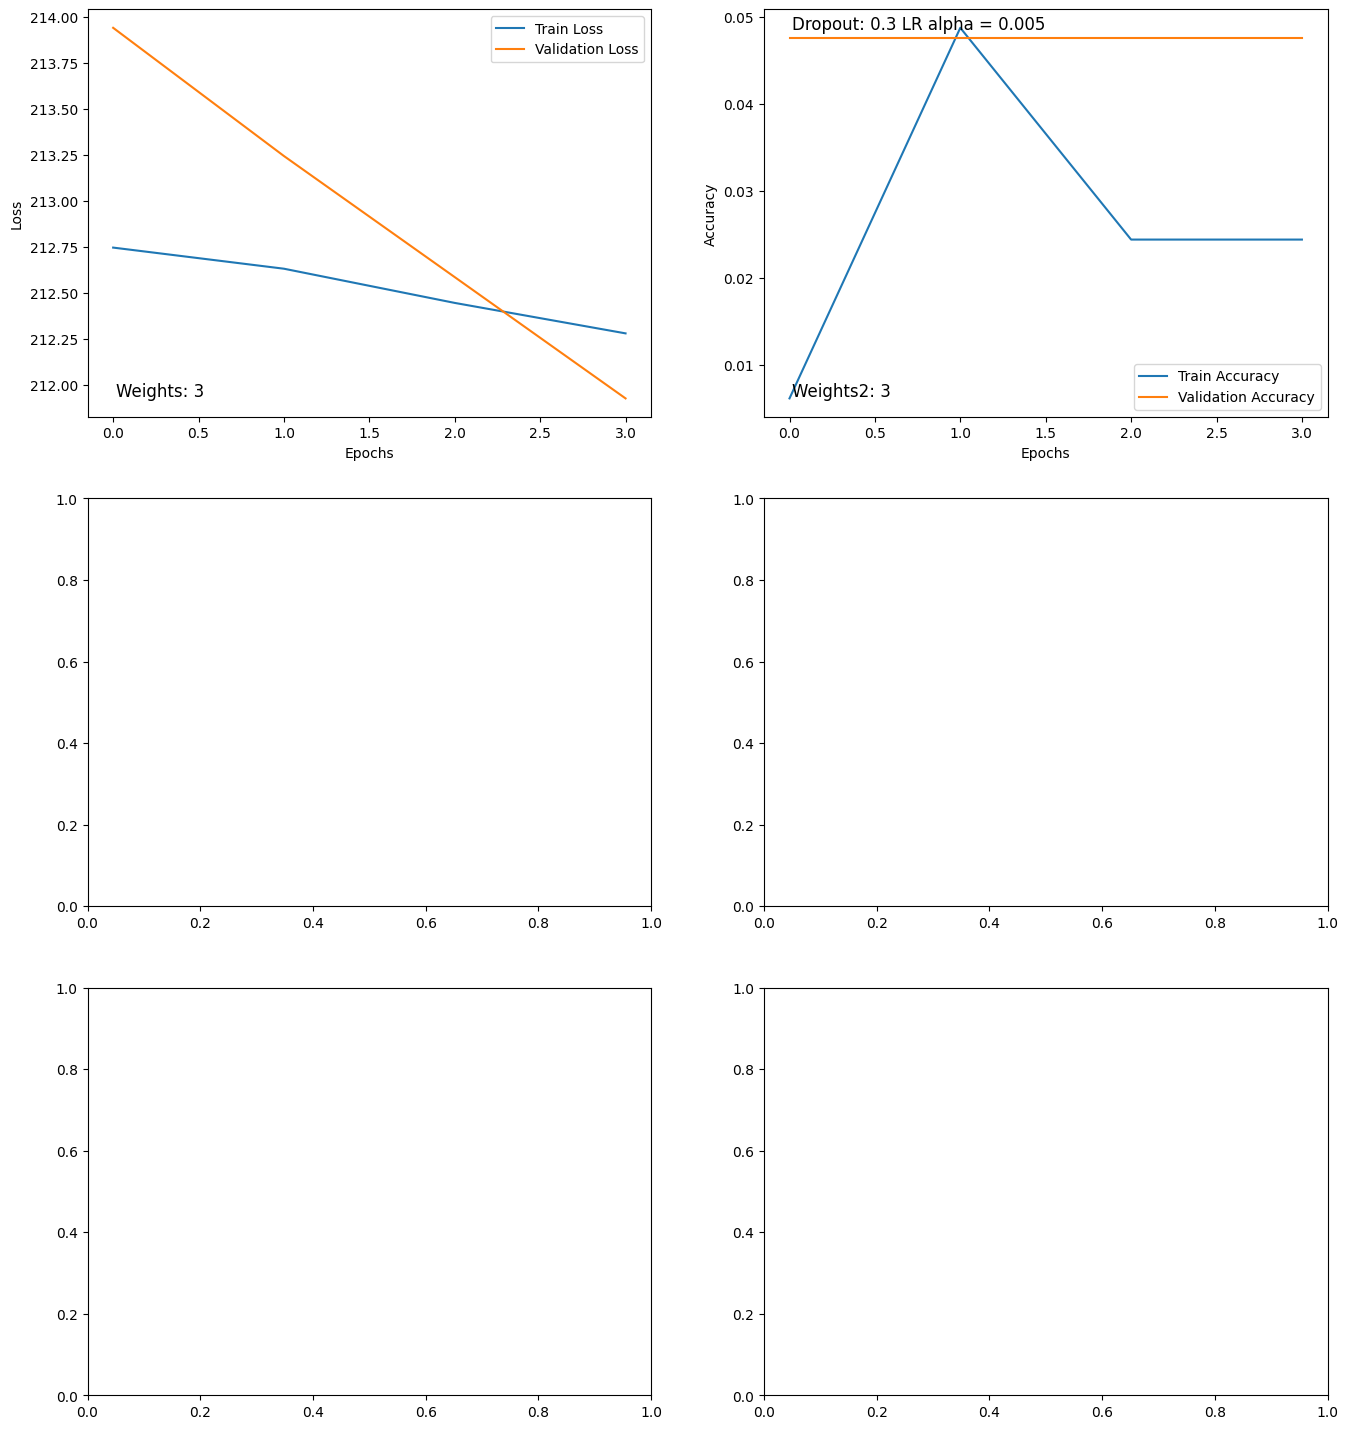

In [215]:

# map_pion = extract_neighborhood_map(candidate_positions = X_test["X_test_pion_candidates"], mip_positions = X_test["X_test_mip_position"], neighborhood_size = 40, map_size = 40)


# # map_sample = map_pion[0]

# # # Plot the map
# # plt.imshow(map_sample, cmap='gray')
# # plt.colorbar()
# # plt.title("Neighborhood Map for num_samples = 1")
# # plt.xlabel("X-axis")
# # plt.ylabel("Y-axis")
# # plt.show()

# map_pion2 = extract_neighborhood_map(candidate_positions = X_test["X_test_kaon_candidates"], mip_positions = X_test["X_test_mip_position"], neighborhood_size = 40, map_size = 40)


# # #map_sample = map_pion[0]

# # # Plot the map
# # plt.imshow(map_sample, cmap='gray')
# # plt.colorbar()
# # plt.title("Neighborhood Map for num_samples = 1")
# # plt.xlabel("X-axis")
# # plt.ylabel("Y-axis")
# # plt.show()
# map_pion = extract_neighborhood_map(candidate_positions = X_test["X_test_proton_candidates"], mip_positions = X_test["X_test_mip_position"], neighborhood_size = 40, map_size = 40)


# #map_sample = map_pion[0]
mask = [1,1,1,1]
classifier.train(X_train = X_train, X_test = X_test, y_train = y_train, y_test = y_test, mask = mask)


In [ ]:
!wget https://raw.githubusercontent.com/eflatlan/CNN_PID/models_sacved/helper_functions.py
from helper_functions import *

In [ ]:
!wget https://raw.githubusercontent.com/eflatlan/CNN_PID/models_sacved/plot_helper_functions.py
from plot_helper_functions import *